In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA


import antares_client

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# set random seed for consistent results
import random
random.seed(0)

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

In [2]:
#dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_90k_tns_df.csv', index_col='ztf_object_id')
dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_tns_df_SMOTE_train_test.csv.gz', compression='gzip', index_col='ztf_object_id')

dataset_bank_tns_df

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21aabyqkf,0.413494,-0.486142,0.375000,0.000000,0.402487,0.826988,0.749877,0.441328,-0.745490,0.011211,...,0.316799,0.441200,0.400200,0.333601,3.467238,0.424334,Yes_TNS,None,-99.00,YSE
ZTF21abvqzzb,0.063600,-0.784491,0.250000,0.000000,0.353365,0.127199,0.127199,0.082748,1.202164,0.002152,...,0.264601,0.263901,0.219700,0.171902,22.579825,0.141305,Yes_TNS,None,-99.00,ALeRCE
ZTF20aczeagg,0.234571,-0.696720,0.333333,0.000000,0.420011,0.469143,0.454590,0.323616,-1.373274,-0.002359,...,0.432600,0.546799,0.582800,0.379801,27.180923,0.559393,Yes_TNS,None,-99.00,Pan-STARRS
ZTF21aakerwn,0.409120,0.006640,0.111111,0.333333,0.355630,0.818239,0.601124,0.241866,2.142633,0.018792,...,0.523100,0.443800,0.468699,0.453501,59.096771,0.224341,Yes_TNS,None,-99.00,ALeRCE
ZTF21aatrtbu,0.269150,-0.339783,0.166667,0.000000,0.387371,0.538300,0.508461,0.239910,1.068675,0.030668,...,0.277599,0.323900,0.233900,0.204599,32.805658,0.201681,Yes_TNS,None,-99.00,ALeRCE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21achkrsw,0.606314,-0.557355,0.250000,0.000000,0.368335,1.212627,0.992335,0.385455,0.972483,0.010188,...,1.180601,1.277901,1.177800,1.204000,33.075407,0.801887,Yes_TNS,None,-99.00,ZTF
ZTF20achtxbi,0.910644,-0.436037,0.411765,0.000000,0.395957,1.821287,1.540865,0.746518,-0.479199,0.018452,...,0.407099,0.514900,0.323200,0.643799,15.380690,1.921385,Yes_TNS,SN Ia,0.07,ALeRCE
ZTF18acbybyq,0.291750,-0.811879,0.200000,0.000000,0.359498,0.583500,0.449288,0.214199,0.079437,0.001047,...,0.361000,0.403599,0.245800,0.216400,24.048442,0.444275,Yes_TNS,None,-99.00,Pan-STARRS


In [3]:
suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_l1norm_AlerceCls_fw_MI_classif_sep_highlighted_SMOTE"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_l1norm_AlerceCls_fw_MI_classif_sep_highlighted"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_l1norm_AlerceCls_fw_MI_classif_LConly"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_noSS_AlerceCls_fw_MI_classif_LConly"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_noSS_AlerceCls_fw_MI_classif_only2"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_after_MI_classif_only"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_after_MI_classif_highlight_sepFs"
#suffix=f"noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_after_fromDict"

ann_num = 350
col_list= [f'dist={col}' for col in range(1, ann_num)]
dist_col = f'Max-{len(col_list)}ANNs'


ann_dist_all_df = pd.read_csv(f'ann_dist_all_df_{suffix}_ann_num={ann_num}.csv', index_col=0)
ann_dist_all_df.index = ann_dist_all_df.index.rename('ztf_object_id')
ann_dist_all_df

,Mean-349ANNs,Max-349ANNs
ztf_object_id,,
ZTF17aadqidc,417.447836,474.746033
ZTF18aaikcbb,853.034655,915.472107
ZTF18aajiirj,606.809796,664.194946
ZTF18aajkgtr,820.527977,920.139282
ZTF18aaqdlle,441.790396,558.945190
...,...,...
ZTF21abwtyle,404.848458,464.641357
ZTF21abxneye,672.895625,796.006287
ZTF21acculro,592.876449,656.032898


In [4]:
merge_df = pd.concat([ann_dist_all_df, dataset_bank_tns_df], axis=1)
merge_df = merge_df[~merge_df.isnull().any(axis=1)]
merge_df

,Mean-349ANNs,Max-349ANNs,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF17aadqidc,417.447836,474.746033,0.118791,-0.558108,0.428571,0.000000,0.385504,0.237581,0.223594,0.138365,...,0.163198,0.160099,0.150101,0.122200,26.155457,0.051662,No_TNS,None,-99.000,None
ZTF18aaikcbb,853.034655,915.472107,0.493197,-0.469863,0.315789,0.162221,0.381336,0.938905,0.705640,0.321501,...,1.036900,1.388600,1.352699,1.262701,126.778223,0.917705,Yes_TNS,SN II,0.044,ATLAS
ZTF18aajiirj,606.809796,664.194946,0.078200,-0.903738,0.500000,0.000000,0.420589,0.156401,0.156401,0.125820,...,0.158300,0.110500,0.138800,0.094400,22.018261,0.402993,Yes_TNS,None,-99.000,ALeRCE
ZTF18aajkgtr,820.527977,920.139282,0.292950,-0.308563,0.250000,0.353553,0.365985,0.585899,0.490854,0.196341,...,0.031200,0.030100,0.076300,-0.004599,42.769297,0.065834,No_TNS,None,-99.000,None
ZTF18aaqdlle,441.790396,558.945190,0.426600,0.104181,0.250000,0.223607,0.110649,0.703610,0.385500,0.164603,...,0.436201,0.386700,0.501400,0.240400,10.946292,1.454977,No_TNS,None,-99.000,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21abwtyle,404.848458,464.641357,0.137787,-0.374292,0.400000,0.000000,0.325139,0.275574,0.275574,0.242085,...,0.221102,0.203400,0.164701,0.164600,15.384990,0.261613,Yes_TNS,None,-99.000,ALeRCE
ZTF21abxneye,672.895625,796.006287,0.037603,-0.378731,0.200000,0.000000,0.269851,0.075207,0.075207,0.060192,...,-0.086000,-0.208099,-0.083599,-0.131001,6.037511,0.118038,Yes_TNS,None,-99.000,ALeRCE
ZTF21acculro,592.876449,656.032898,0.556129,-0.376353,0.250000,0.000000,0.372163,1.112259,0.951672,0.492085,...,1.109301,0.932199,1.102501,1.039600,67.970419,1.230419,Yes_TNS,None,-99.000,AMPEL


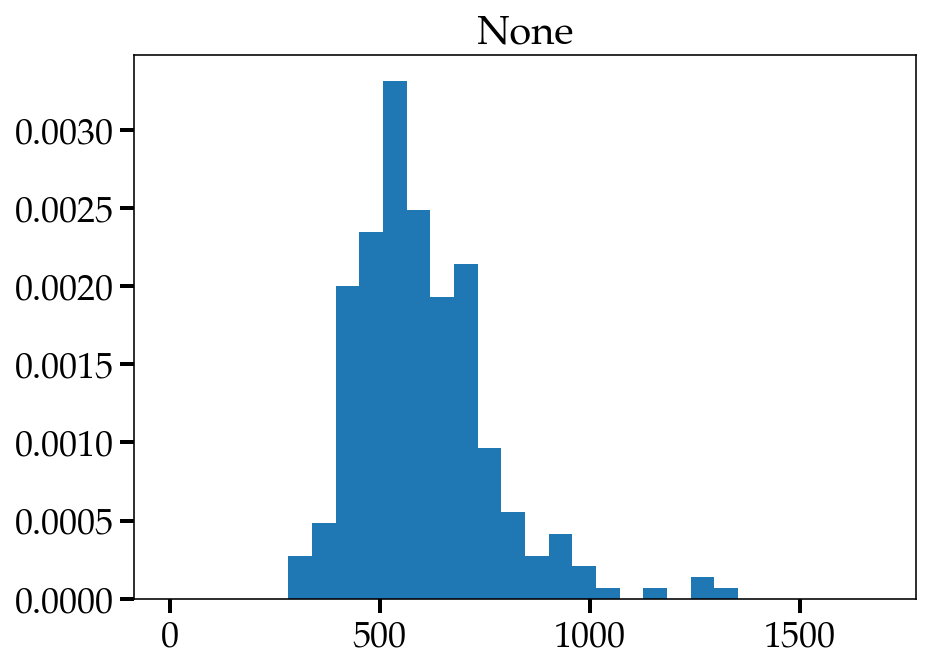

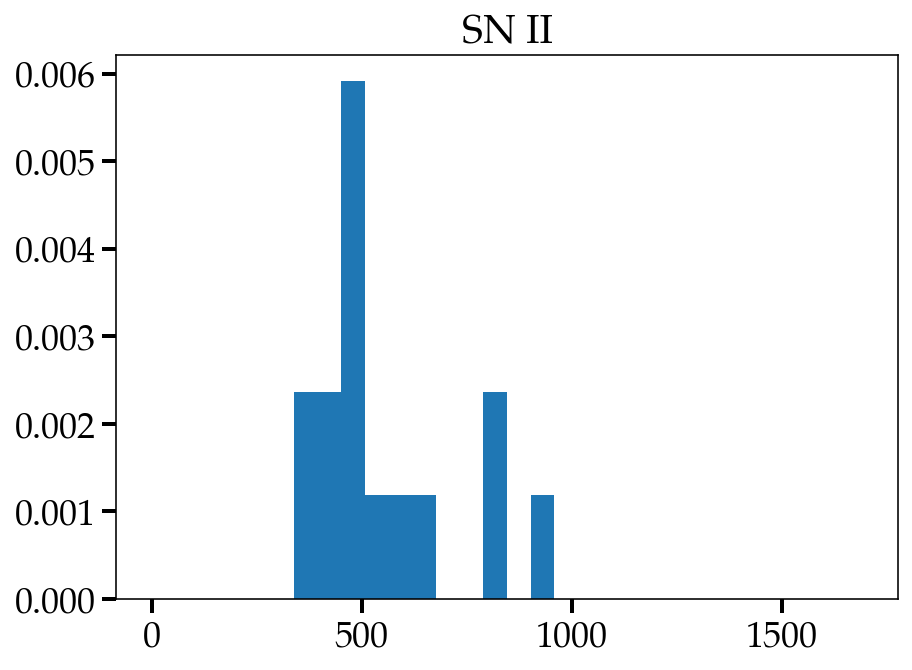

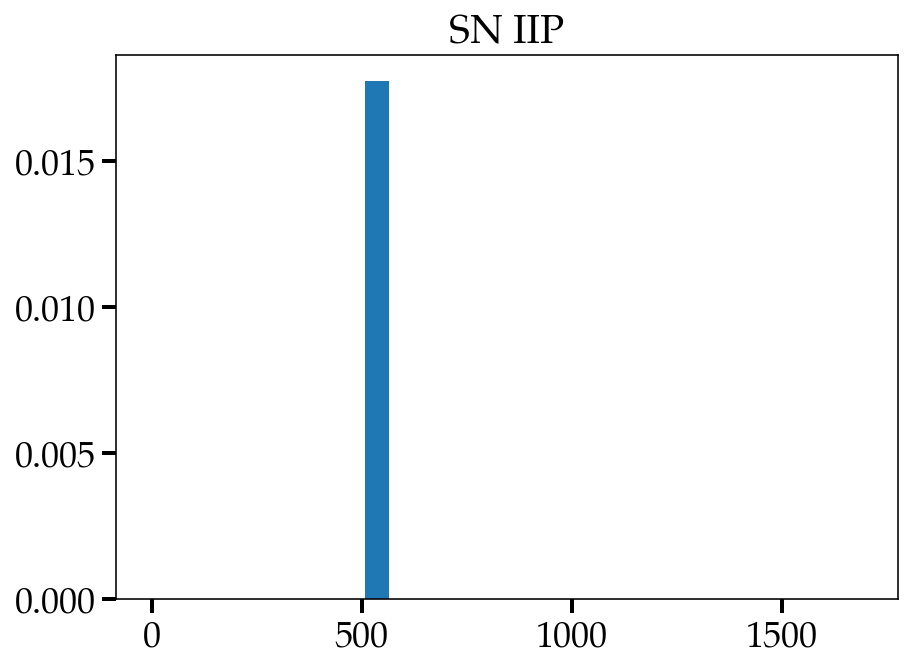

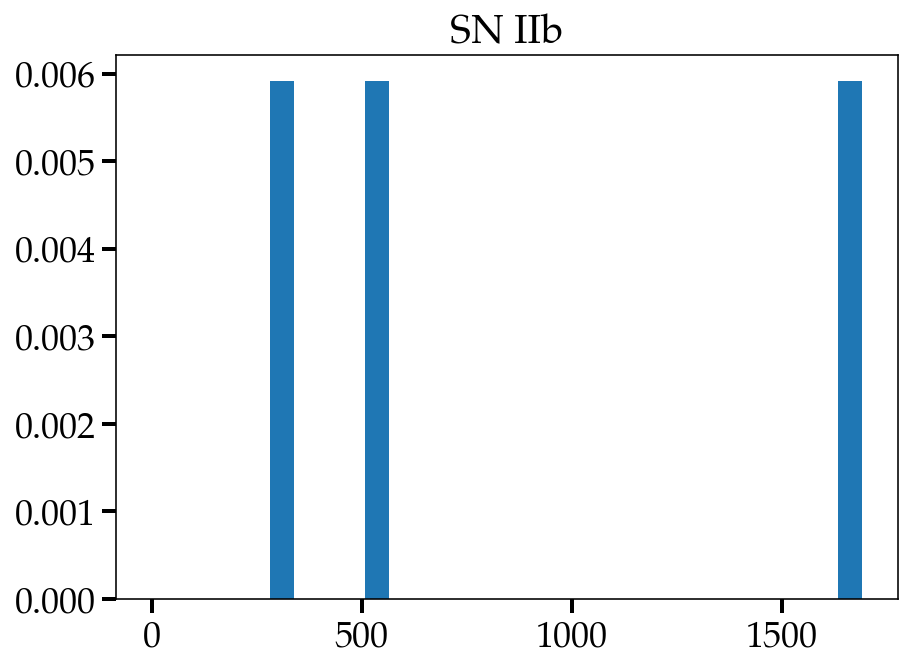

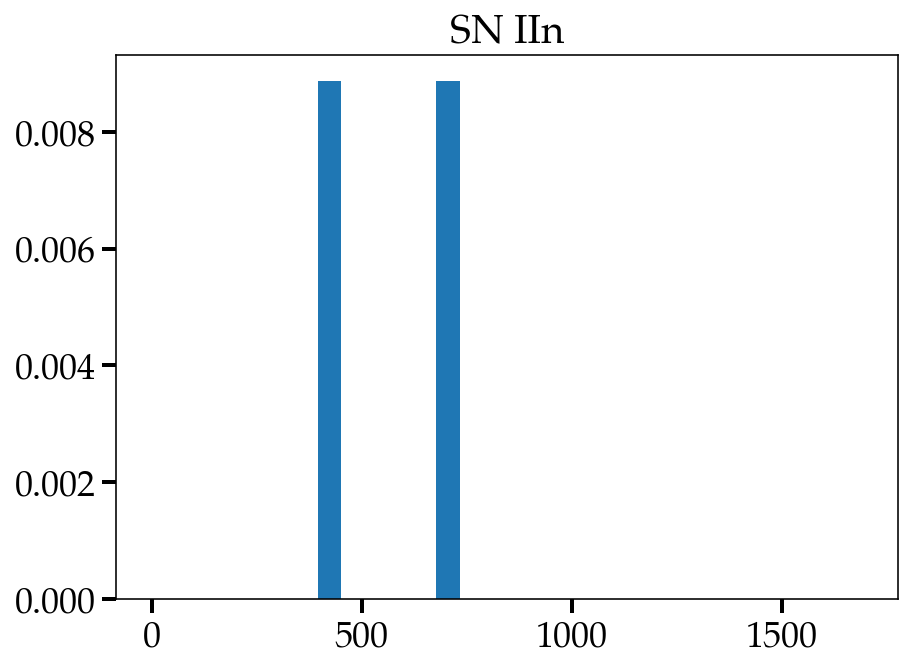

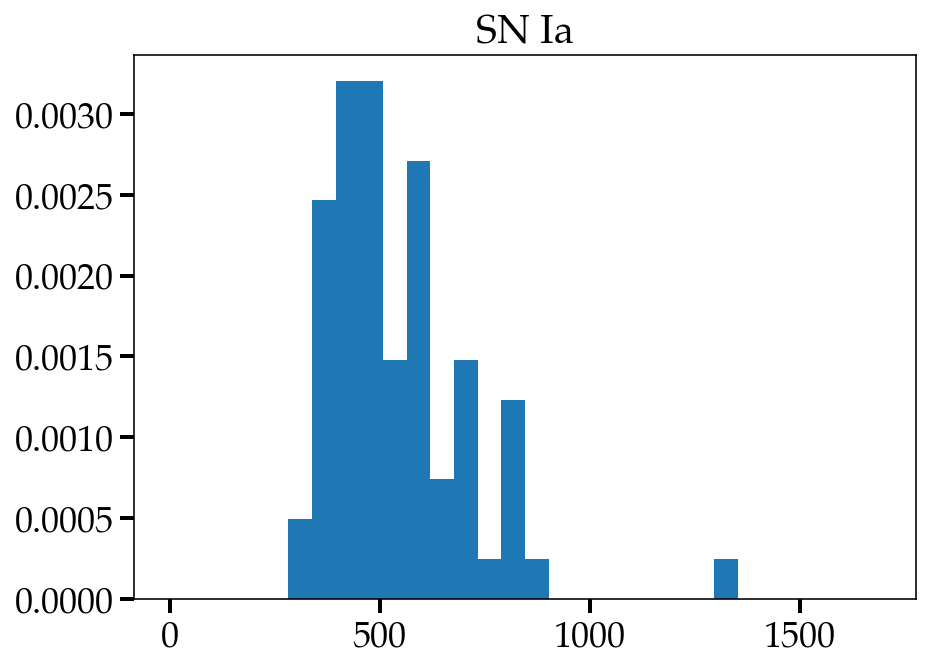

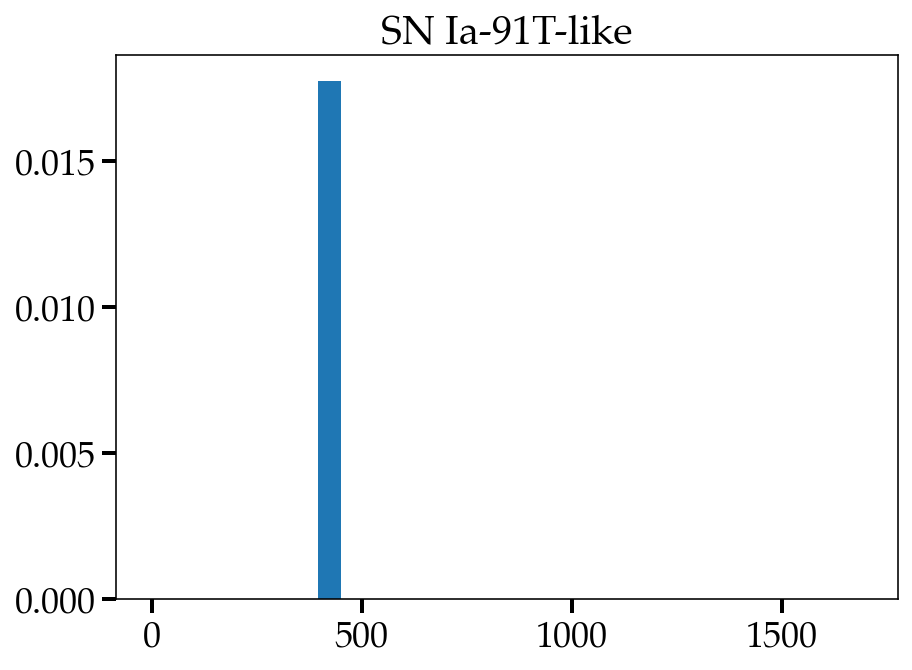

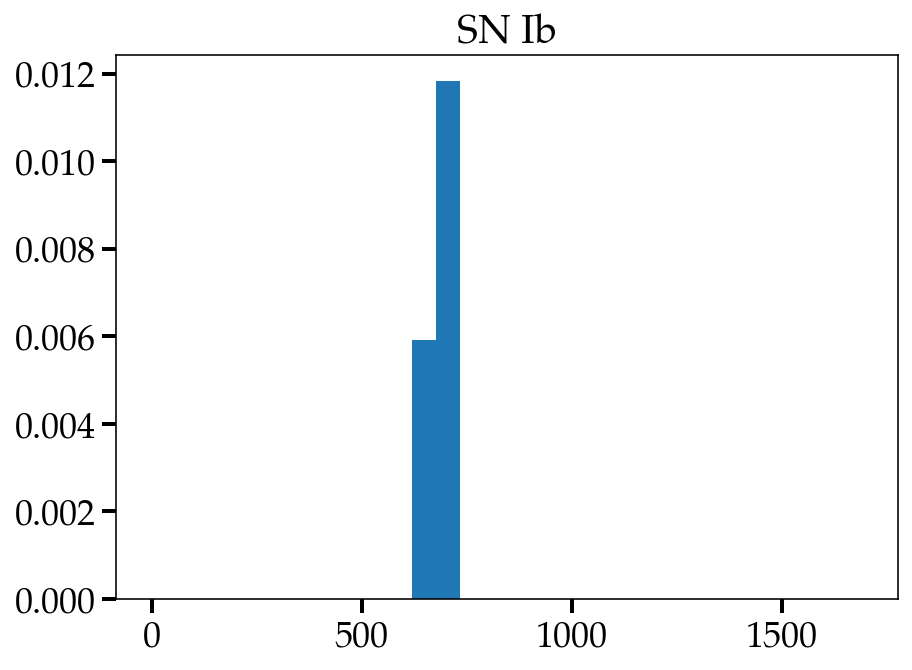

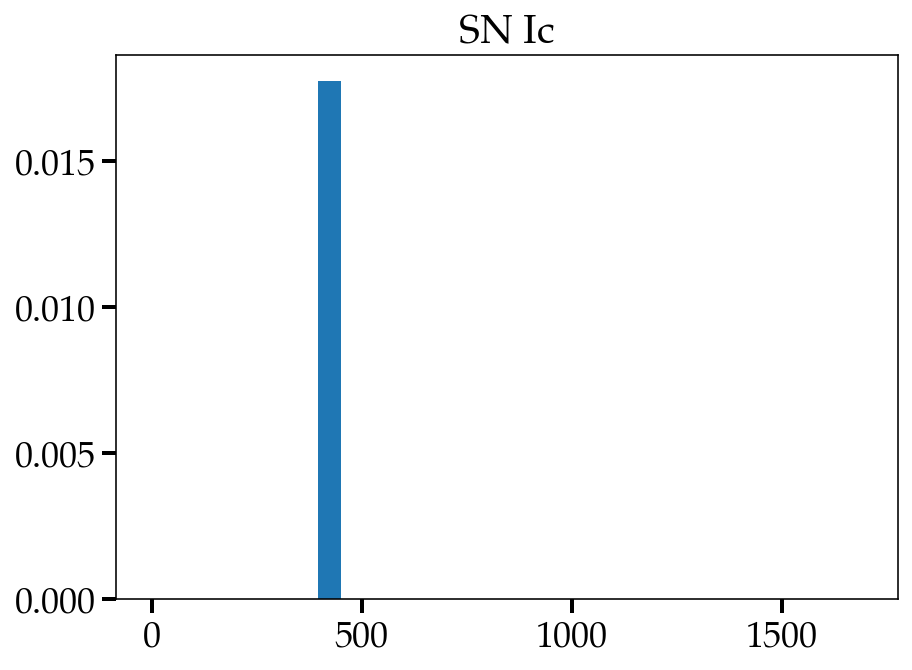

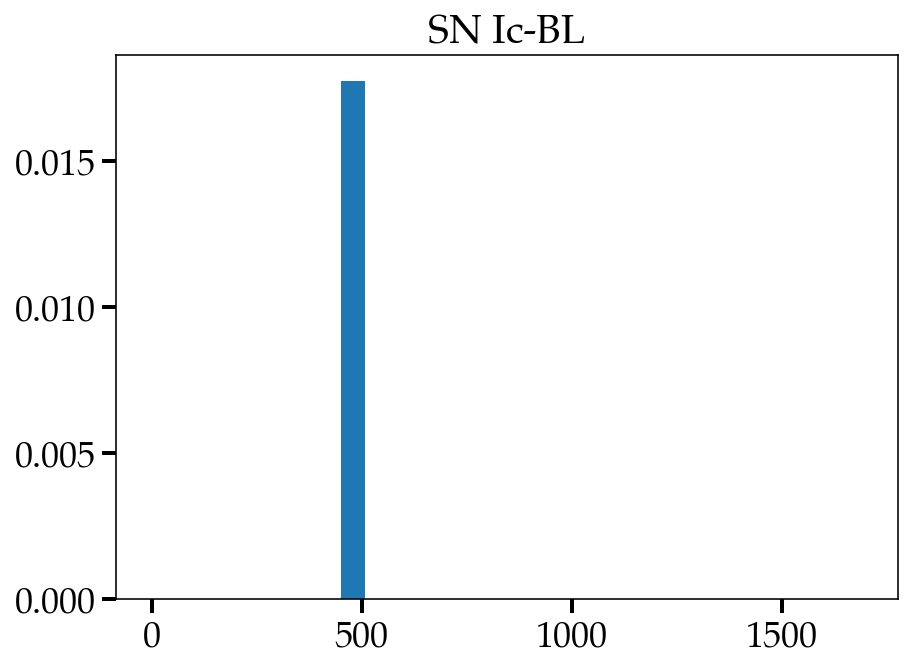

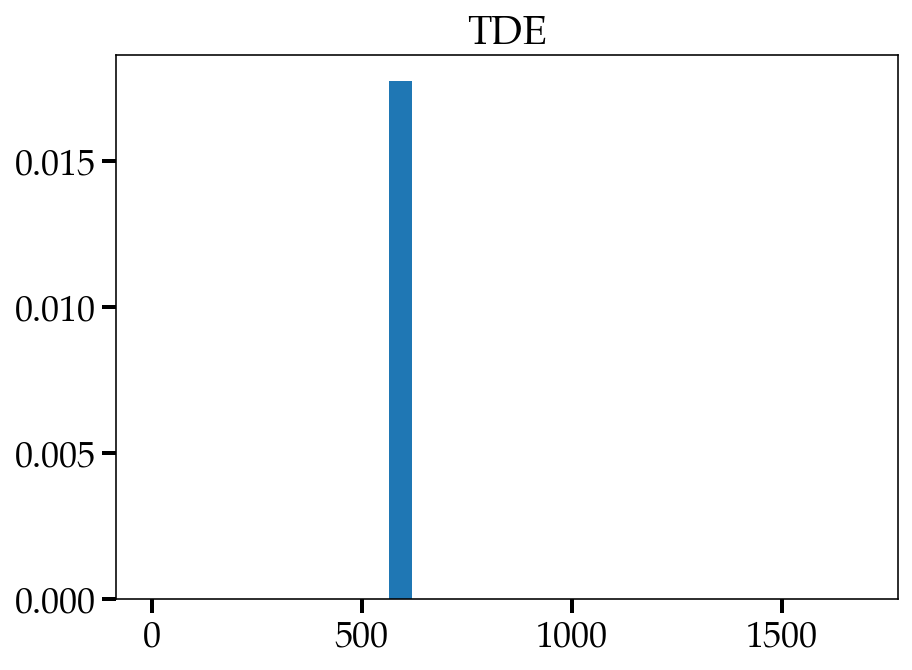

In [5]:
for cls in np.unique(merge_df.tns_cls):
    fig, ax = plt.subplots()
    
    merge_df_cls = merge_df[merge_df.tns_cls == cls]
    
    #ax.hist(merge_df_cls["WeightedMean-9ANNs"], bins=np.linspace(0, np.max(merge_df["WeightedMean-9ANNs"]), 31), density=True)
    ax.hist(merge_df_cls[dist_col], bins=np.linspace(0, np.max(merge_df[dist_col]), 31), density=True)
    
    ax.set_title(cls)
    #ax.set_xlim(0, 150)

/Users/patrickaleo/miniconda3/envs/laiss/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/patrickaleo/miniconda3/envs/laiss/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


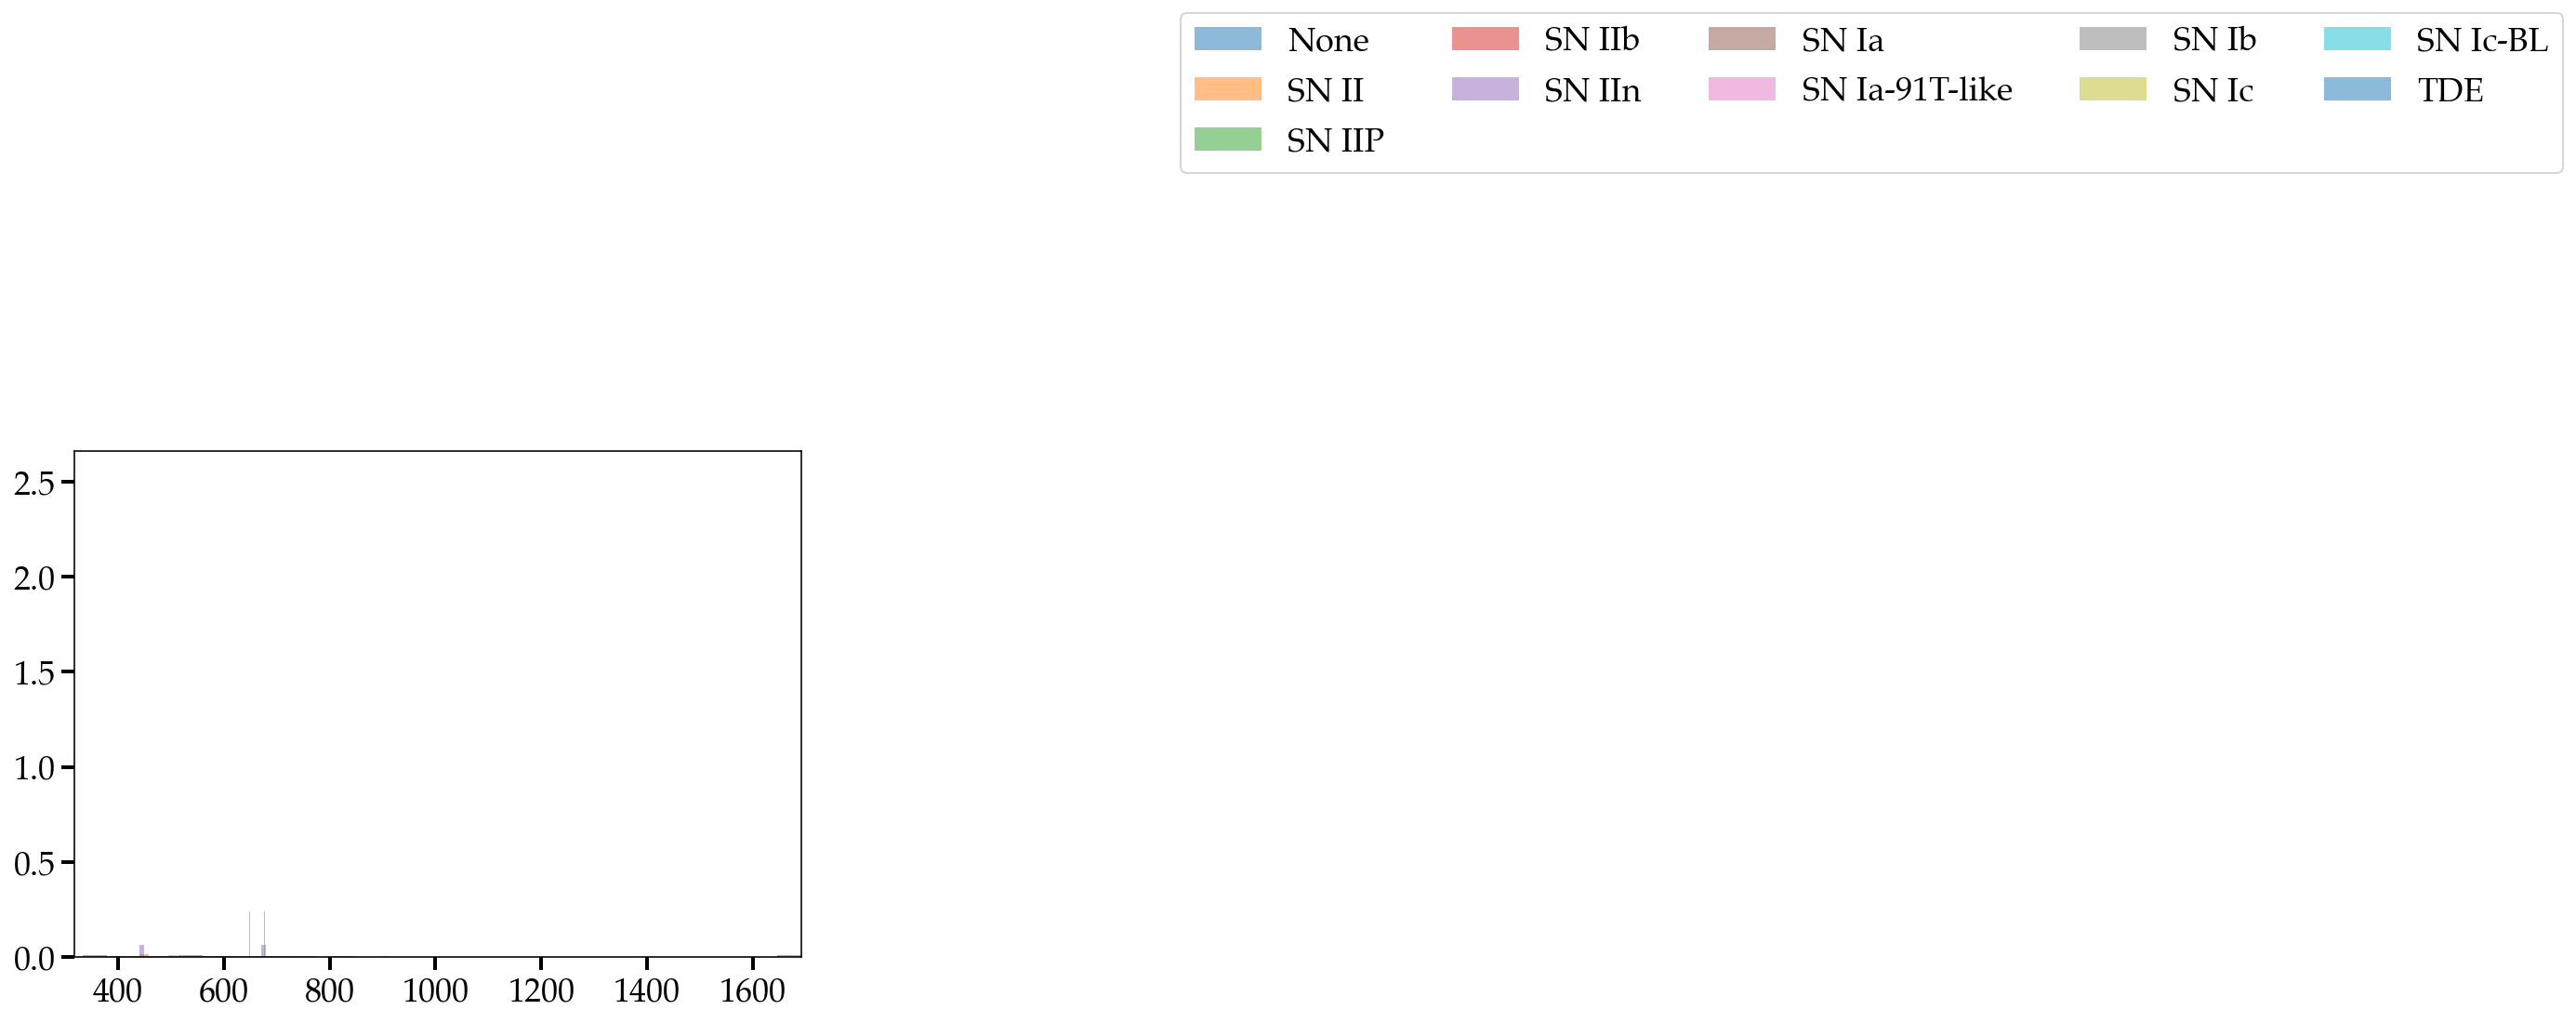

In [6]:
fig, ax = plt.subplots()

for cls in np.unique(merge_df.tns_cls):
    
    merge_df_cls = merge_df[merge_df.tns_cls == cls]
    
    #ax.hist(merge_df_cls["WeightedMean-9ANNs"], bins=np.linspace(0, 150, 31), 
    #        density=True, alpha=0.5, label=cls)
    
    ax.hist(merge_df_cls[dist_col], bins=np.linspace(np.min(merge_df_cls[dist_col]), np.max(merge_df_cls[dist_col]), 31), 
            density=True, alpha=0.5, label=cls)
    
plt.xlim(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]))
plt.legend(ncol=5, bbox_to_anchor=(1.5,1.9))

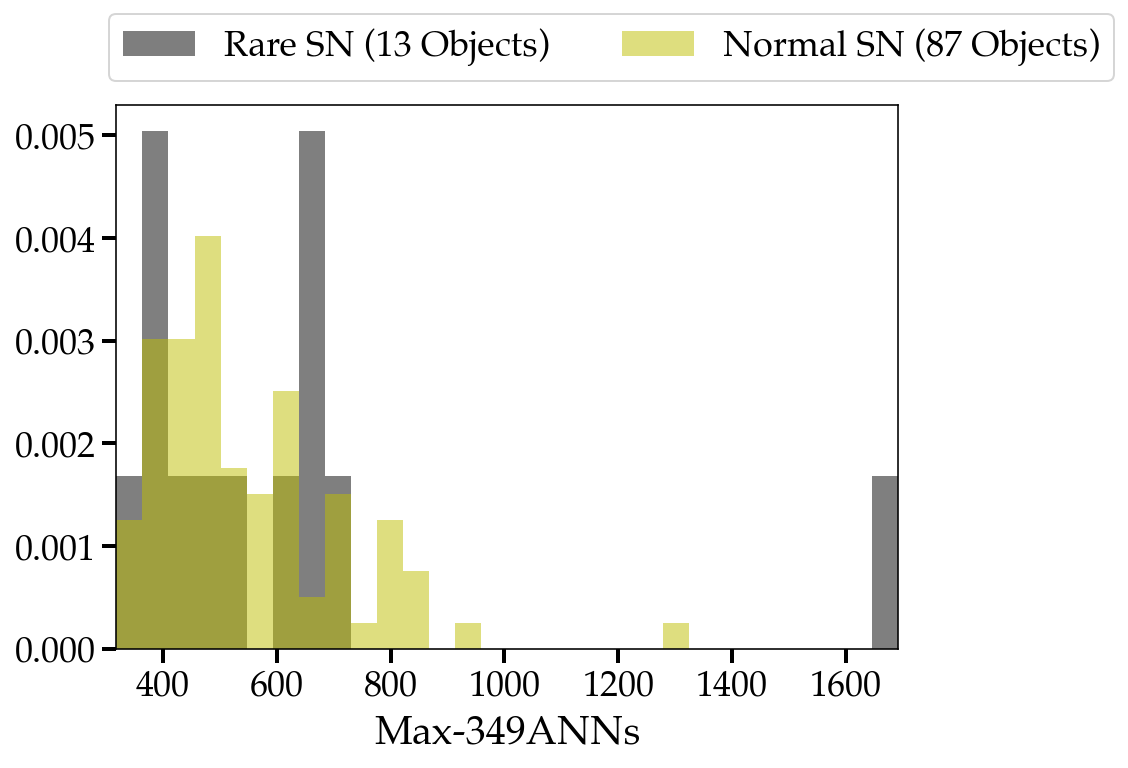

In [7]:
fig, ax = plt.subplots()
bins=np.linspace(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]), 31)
    

rare_sn_l = ['SLSN-I', 'SLSN-II', 'SN II-pec', 'SN IIb', 'SN IIn', 'SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-CSM',
   'SN Ia-pec', 'SN Iax[02cx-like]', 'SN Ib', 'SN Ib-pec', 'SN Ib/c',
   'SN Ibn', 'SN Ic', 'SN Ic-BL', 'SN Icn', 'TDE']
rare_sn_df = merge_df[merge_df.tns_cls.isin(rare_sn_l)]
ax.hist(rare_sn_df[dist_col], bins=bins, 
        density=True, alpha=0.5, color="k", label=f"Rare SN ({len(rare_sn_df)} Objects)")

# none_l = ['None']
# none_df = merge_df[merge_df.tns_cls.isin(none_l)]
# ax.hist(none_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="m",label="None")

normal_sn_l = ['SN', 'SN I', 'SN II', 'SN Ia']
normal_sn_df = merge_df[merge_df.tns_cls.isin(normal_sn_l)]
ax.hist(normal_sn_df[dist_col], bins=bins, 
        density=True, alpha=0.5, color="y", label=f"Normal SN ({len(normal_sn_df)} Objects)")

# not_sn_l = ['AGN', 'CV', 'Nova']
# not_sn_df = merge_df[merge_df.tns_cls.isin(not_sn_l)]
# ax.hist(not_sn_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="c", label="Not SN")
    
plt.xlim(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]))
#plt.xscale('log')
plt.xlabel(dist_col)
plt.legend(ncol=4, bbox_to_anchor=(1.3,1.2));
plt.savefig(f'../figures/histograms/ann_dist_all_df_{suffix}_2cls_{dist_col}.png')
plt.show()

In [8]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test

# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_sn_df[dist_col], size=len(rare_sn_df), replace=False)
    stat, p_value = ks_2samp(rare_sn_df[dist_col], normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.23076923076923078
P-value: 0.7414226256177527
The two distributions are likely the same.


In [9]:
np.median(normal_sn_df[dist_col])

497.02728271484375

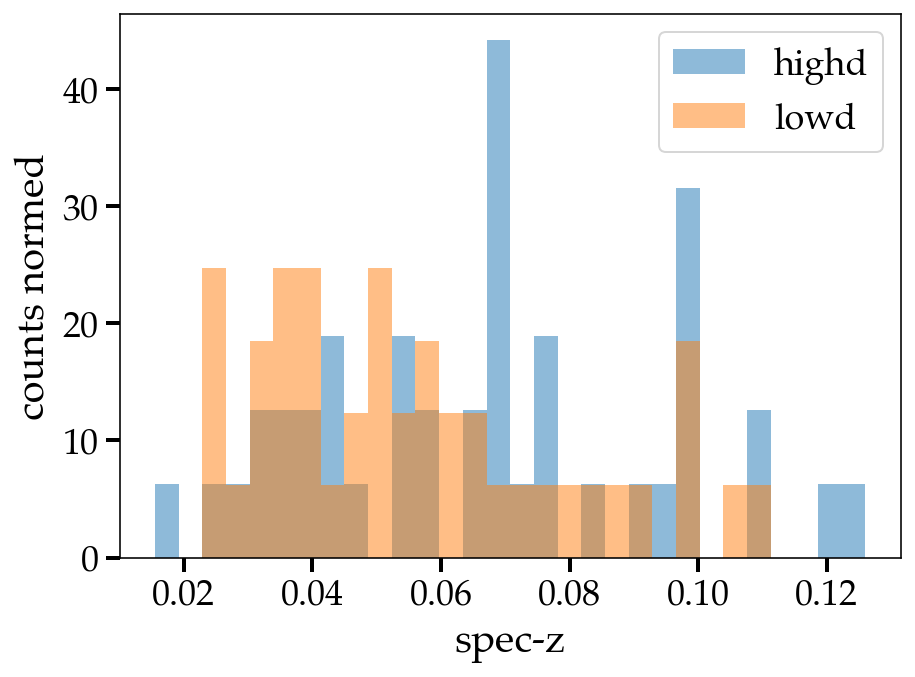

In [10]:
normal_sn_df = normal_sn_df[normal_sn_df.spec_z >= 0]

normal_sn_highd_df = normal_sn_df[normal_sn_df[dist_col] >= 500]
normal_sn_lowd_df = normal_sn_df[normal_sn_df[dist_col] <= 500]

bins=np.linspace(np.min(normal_sn_highd_df.spec_z), np.max(normal_sn_highd_df.spec_z), 31)
plt.hist(normal_sn_highd_df.spec_z, bins=bins, alpha=0.5, density=True, label='highd')
plt.hist(normal_sn_lowd_df.spec_z, bins=bins, alpha=0.5, density=True, label='lowd')
plt.xlabel('spec-z')
plt.ylabel('counts normed')
plt.legend()

In [11]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_sn_lowd_df.spec_z, size=len(normal_sn_highd_df), replace=False)
    stat, p_value = ks_2samp(normal_sn_highd_df.spec_z, normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.2558139534883721
P-value: 0.09881038723668262
The two distributions are likely the same.


In [12]:
np.median(rare_sn_df[dist_col])

543.9226684570312

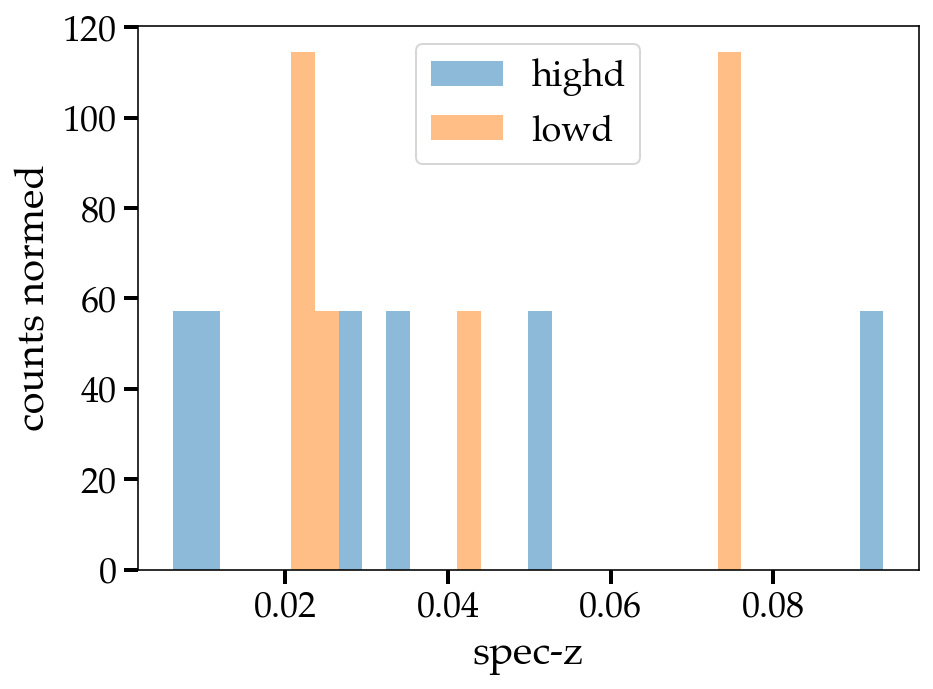

In [16]:
rare_sn_df = rare_sn_df[rare_sn_df.spec_z >= 0]

rare_sn_highd_df = rare_sn_df[rare_sn_df[dist_col] >= 550]
rare_sn_lowd_df = rare_sn_df[rare_sn_df[dist_col] <= 550]

bins=np.linspace(np.min(rare_sn_highd_df.spec_z), np.max(rare_sn_highd_df.spec_z), 31)
plt.hist(rare_sn_highd_df.spec_z, bins=bins, alpha=0.5, density=True, label='highd')
plt.hist(rare_sn_lowd_df.spec_z, bins=bins, alpha=0.5, density=True, label='lowd')
plt.xlabel('spec-z')
plt.ylabel('counts normed')
plt.legend()

In [17]:
len(rare_sn_lowd_df)

7

In [18]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(rare_sn_lowd_df.spec_z, size=len(rare_sn_highd_df), replace=False)
    stat, p_value = ks_2samp(rare_sn_highd_df.spec_z, normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.3333333333333333
P-value: 0.930735930735931
The two distributions are likely the same.


fig, ax = plt.subplots()
bins=np.linspace(25, 150, 31)
    

rare_sn_l = ['SLSN-I', 'SLSN-II', 'SN II-pec', 'SN IIb', 'SN IIn', 'SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-CSM',
   'SN Ia-pec', 'SN Iax[02cx-like]', 'SN Ib', 'SN Ib-pec', 'SN Ib/c',
   'SN Ibn', 'SN Ic', 'SN Ic-BL', 'SN Icn', 'TDE']
rare_sn_df = merge_df[merge_df.tns_cls.isin(rare_sn_l)]
ax.hist(rare_sn_df["Mean-49ANNs"], bins=bins, 
        density=True, alpha=0.5, color="k", label=f"Rare SN ({len(rare_sn_df)} Objects)")

# none_l = ['None']
# none_df = merge_df[merge_df.tns_cls.isin(none_l)]
# ax.hist(none_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="m",label="None")

normal_sn_l = ['SN', 'SN I', 'SN II', 'SN Ia']
normal_sn_df = merge_df[merge_df.tns_cls.isin(normal_sn_l)]
ax.hist(normal_sn_df["Mean-49ANNs"], bins=bins, 
        density=True, alpha=0.5, color="y", label=f"Normal SN ({len(normal_sn_df)} Objects)")

# not_sn_l = ['AGN', 'CV', 'Nova']
# not_sn_df = merge_df[merge_df.tns_cls.isin(not_sn_l)]
# ax.hist(not_sn_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="c", label="Not SN")
    
plt.xlim(25, 150)
plt.xlabel('Mean-49ANNs')
plt.legend(ncol=4, bbox_to_anchor=(1.3,1.2));
plt.savefig('../figures/histograms/ann_dist_all_df_hasTNS_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_2cls_Mean.png')
plt.show()

from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_sn_df["Mean-49ANNs"], size=len(rare_sn_df), replace=False)
    stat, p_value = ks_2samp(rare_sn_df["Mean-49ANNs"], normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

## No statistical difference between Rare SN and Normal SN 

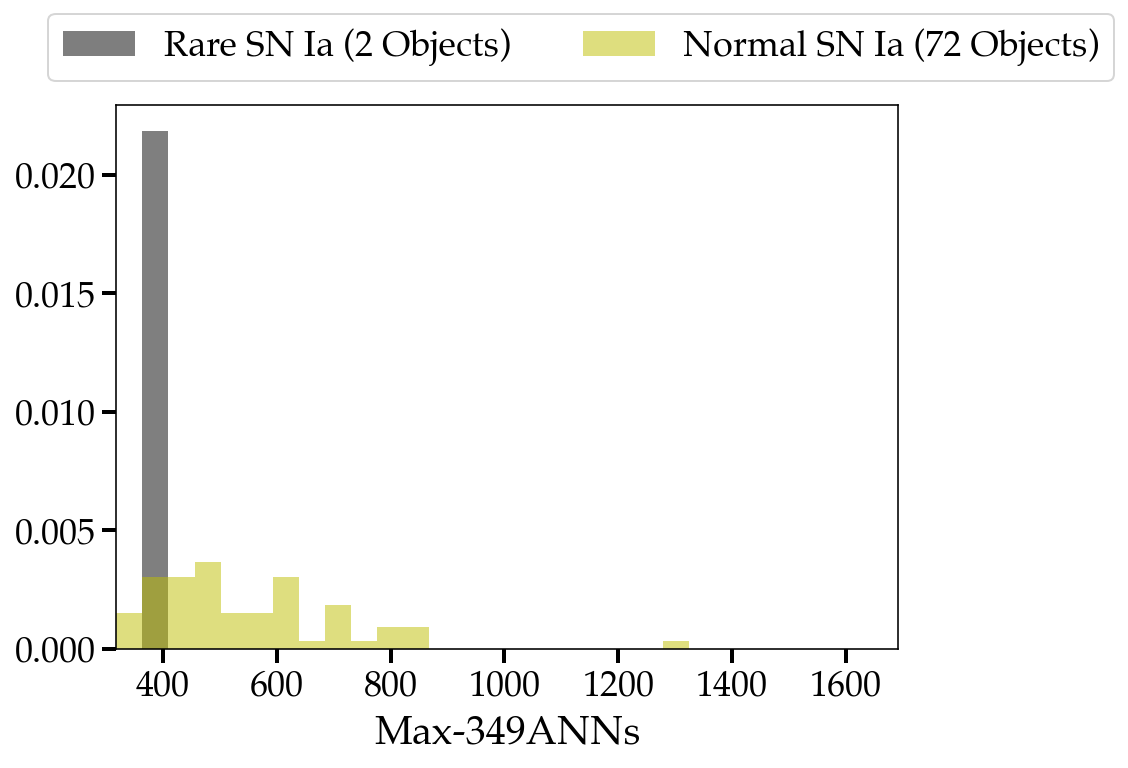

In [19]:
fig, ax = plt.subplots()
bins=np.linspace(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]), 31)
    

rare_snIa_l = ['SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-CSM', 'SN Ia-pec', 'SN Iax[02cx-like]']
rare_snIa_df = merge_df[merge_df.tns_cls.isin(rare_snIa_l)]
ax.hist(rare_snIa_df[dist_col], bins=bins, 
        density=True, alpha=0.5, color="k", label=f"Rare SN Ia ({len(rare_snIa_df)} Objects)")

# none_l = ['None']
# none_df = merge_df[merge_df.tns_cls.isin(none_l)]
# ax.hist(none_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="m",label="None")

normal_snIa_l = ['SN Ia']
normal_snIa_df = merge_df[merge_df.tns_cls.isin(normal_snIa_l)]
ax.hist(normal_snIa_df[dist_col], bins=bins, 
        density=True, alpha=0.5, color="y", label=f"Normal SN Ia ({len(normal_snIa_df)} Objects)")

# not_sn_l = ['AGN', 'CV', 'Nova']
# not_sn_df = merge_df[merge_df.tns_cls.isin(not_sn_l)]
# ax.hist(not_sn_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="c", label="Not SN")
    
plt.xlim(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]))
plt.xlabel(dist_col)
plt.legend(ncol=4, bbox_to_anchor=(1.3,1.2));
plt.savefig(f'../figures/histograms/ann_dist_all_df_{suffix}_2cls_{dist_col}_Ia.png')
plt.show()

In [20]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_snIa_subsample = np.random.choice(normal_snIa_df[dist_col], size=len(rare_snIa_df), replace=False)
    stat, p_value = ks_2samp(rare_snIa_df[dist_col], normal_snIa_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.5
P-value: 0.5173333333333333
The two distributions are likely the same.


## No statistical difference between Rare SN Ia and Normal SN Ia...

In [21]:
np.median(normal_snIa_df[dist_col])

497.740478515625

In [22]:
normal_snIa_highd_df = normal_snIa_df[normal_snIa_df[dist_col] >= 500]
normal_snIa_lowd_df = normal_snIa_df[normal_snIa_df[dist_col] <= 500]

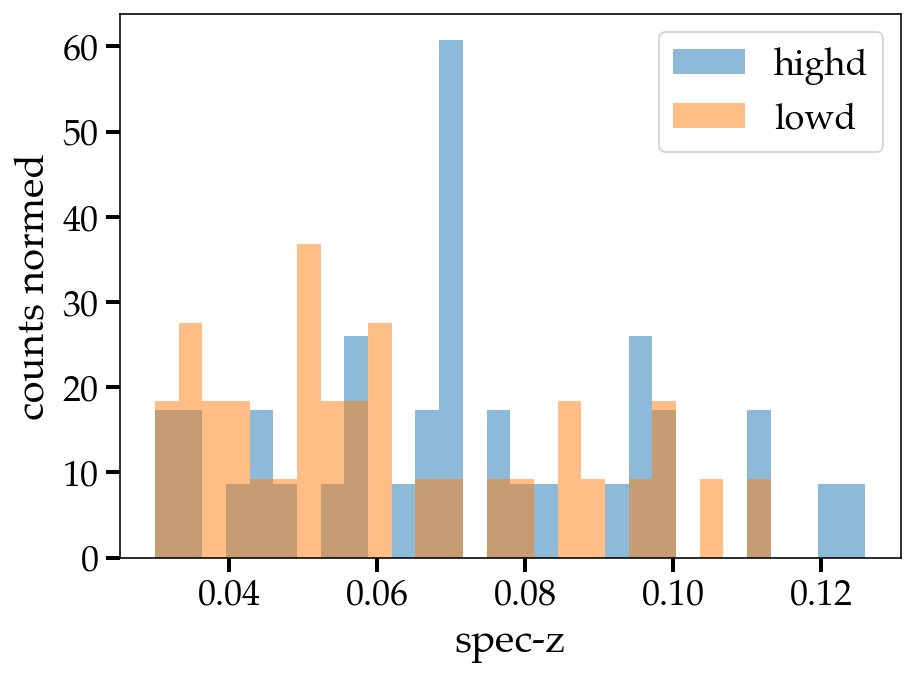

In [23]:
normal_snIa_highd_df = normal_snIa_highd_df[normal_snIa_highd_df.spec_z >= 0]

bins=np.linspace(np.min(normal_snIa_highd_df.spec_z), np.max(normal_snIa_highd_df.spec_z), 31)
plt.hist(normal_snIa_highd_df.spec_z, bins=bins, alpha=0.5, density=True, label='highd')
plt.hist(normal_snIa_lowd_df.spec_z, bins=bins, alpha=0.5, density=True, label='lowd')
plt.xlabel('spec-z')
plt.ylabel('counts normed')
plt.legend()

In [25]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_snIa_lowd_df.spec_z, size=len(normal_snIa_highd_df), replace=False)
    stat, p_value = ks_2samp(normal_snIa_highd_df.spec_z, normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.3333333333333333
P-value: 0.03593229829749474
The two distributions are likely different.


In [26]:
np.median(rare_snIa_df[dist_col])

399.3769836425781

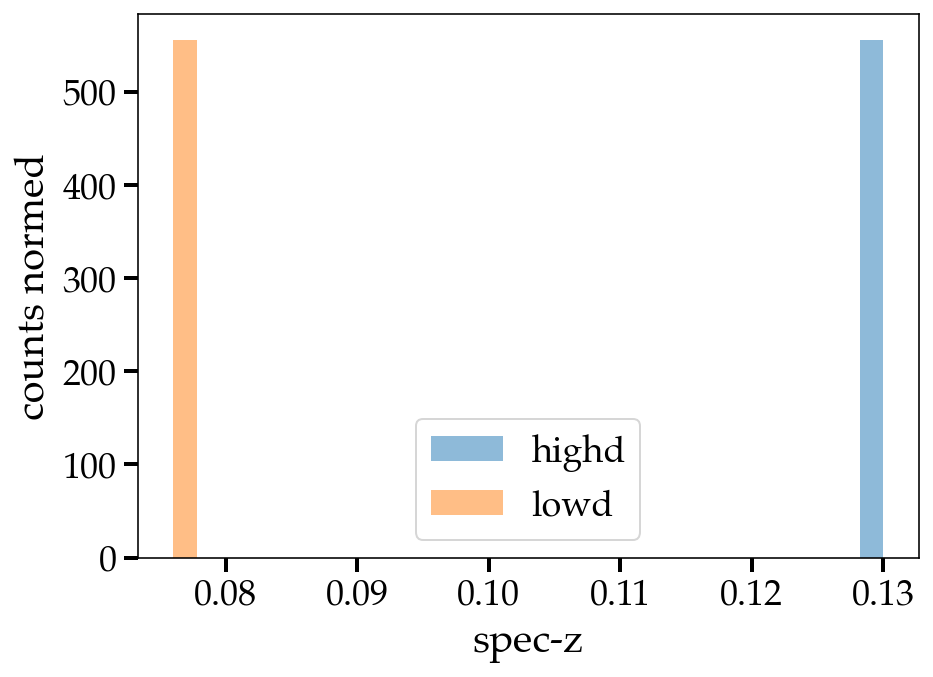

In [29]:
rare_snIa_df = rare_snIa_df[rare_snIa_df.spec_z>=0]

rare_snIa_highd_df = rare_snIa_df[rare_snIa_df[dist_col] >= 400]
rare_snIa_lowd_df = rare_snIa_df[rare_snIa_df[dist_col] <= 400]

bins=np.linspace(np.min(rare_snIa_df.spec_z), np.max(rare_snIa_df.spec_z), 31)

plt.hist(rare_snIa_highd_df.spec_z, bins=bins, alpha=0.5, density=True, label='highd')
plt.hist(rare_snIa_lowd_df.spec_z, bins=bins, alpha=0.5, density=True, label='lowd')
plt.xlabel('spec-z')
plt.ylabel('counts normed')
plt.legend()

In [30]:
len(rare_snIa_highd_df)

1

In [31]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(rare_snIa_lowd_df.spec_z, size=len(rare_snIa_highd_df), replace=False)
    stat, p_value = ks_2samp(rare_snIa_highd_df.spec_z, normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 1.0
P-value: 1.0
The two distributions are likely the same.


# Objs w/ high distances ANNs are Bright/closeby (generally...)
# TODO: how to define "rare"? --> Closeby & bright or rare phenomenology or ???
# Maybe "normalize out" brightness to focus on truly rare SN classes/types/ LCs?

# UPDATED: brightness CAN be normalized out (w/ l1 norm and MI_classif), but tradeoff between good similarity (and host galaxy). If host gal weights all = 0.008 (1/120), then sim is good but high d and low d correspond to low z and high z, respectively. However, if I don't overweight hosts, sim search is not as good but high d and low d DO NOT correspond to low z and high z. So high d and low d objects are not dependent on redshift! But still no diff between rare SN and normal SN ... :( ?

# L1 norm & MI_classif (+changes) normalizes brightness ANN d but not great at AD, but Standard Scaler & MI_classif (+changes) is good at Sim Search, but not great at AD. What is great at AD if features overlap??? Try other scalers?

## TODO: find a new method for really Rare SN!
## TODO: Also, find if Rare SN--> Rare SN and Normal SN --> Normal SN

In [32]:
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_after"
#suffix="hasTNS-spec_NOpca_noCadence_NOtransf_HasHostGalOnly_SS"
#suffix="hasTNS_NOpca_noCadence_NOtransf_HasHostGalOnly_SS"

full_ann_properties_df = pd.read_csv(f'../dataframes/full_ann_properties_df_{suffix}.csv', index_col=0)
full_ann_properties_df

,ann=0_ztfid,ann=1_ztfid,ann=2_ztfid,ann=3_ztfid,ann=4_ztfid,ann=5_ztfid,ann=6_ztfid,ann=7_ztfid,ann=8_ztfid,ann=9_ztfid,...,ann=1_spec_z,ann=2_spec_z,ann=3_spec_z,ann=4_spec_z,ann=5_spec_z,ann=6_spec_z,ann=7_spec_z,ann=8_spec_z,ann=9_spec_z,ann=10_spec_z
ZTF21aasfdps,ZTF21aasfdps,ZTF18accupqk,ZTFabc14262,ZTFabc00290,ZTFabc02615,ZTFabc19320,ZTFabc43718,ZTFabc17189,ZTFabc12851,ZTFabc57160,...,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.0,-99.000,-99.0
ZTF21aapoiht,ZTF21aapoiht,ZTFabc69452,ZTFabc48129,ZTFabc79032,ZTFabc57834,ZTF20acpiesv,ZTFabc95437,ZTFabc11470,ZTFabc21483,ZTFabc57233,...,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.0,-99.000,-99.0
ZTF18abavruc,ZTF18abavruc,ZTFabc64282,ZTFabc83469,ZTFabc42359,ZTFabc34854,ZTFabc17459,ZTF20abzuhfn,ZTFabc94201,ZTFabc30966,ZTFabc11581,...,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.0,-99.000,-99.0
ZTF21aarwwzd,ZTF21aarwwzd,ZTFabc11353,ZTFabc39808,ZTFabc03486,ZTF20acowqyb,ZTFabc52774,ZTFabc94480,ZTFabc52203,ZTFabc34257,ZTF20acnzzlo,...,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.0,-99.000,-99.0
ZTF20acpumut,ZTF20acpumut,ZTFabc67815,ZTF21aarbczp,ZTF21abfnjya,ZTF21aatwhta,ZTF21abkmnrx,ZTFabc88790,ZTF21aaaajfe,ZTF21aaacwmx,ZTF21abrzdqx,...,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,0.05,-99.0,0.066,-99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21achkrsw,ZTF21achkrsw,ZTF21abmwmnp,ZTFabc88210,ZTF18acefgee,ZTF21aapixtz,ZTF21aagyvvs,ZTF21aanyfxr,ZTF18adbhgwx,ZTF21aaaszmm,ZTFabc51648,...,0.096,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.0,-99.000,-99.0
ZTF20achtxbi,ZTF20achtxbi,ZTF21aawtaxi,ZTF21aazlakx,ZTFabc77517,ZTFabc71030,ZTF20acpmntn,ZTF21aaisube,ZTF18acnmicp,ZTF21aazrhhj,ZTFabc29741,...,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.0,-99.000,-99.0
ZTF18acbybyq,ZTF18acbybyq,ZTF21aahqejb,ZTF19aarzfoz,ZTF18acbwabp,ZTF21aakytjh,ZTF21aardzpj,ZTF21abkjsnc,ZTF21aagoqez,ZTFabc19306,ZTFabc65066,...,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.0,-99.000,-99.0
ZTF20acekgpt,ZTF20acekgpt,ZTF21aajfqxi,ZTF21aaronfp,ZTF19aallshi,ZTF21abbpomb,ZTF21abryffa,ZTFabc66532,ZTF19aadgumh,ZTF21aadipjb,ZTF21aawgzty,...,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.0,-99.000,-99.0


In [33]:
full_ann_tns_cls_df = full_ann_properties_df.iloc[:, 33:44]
full_ann_tns_cls_df

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,ann=10_tns_cls
ZTF21aasfdps,None,None,SN IIn,SN IIn,SN IIn,SN Ia,SN IIn,SN IIn,SN II,SN II,SN IIn
ZTF21aapoiht,None,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,None,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP
ZTF18abavruc,None,TDE,TDE,TDE,TDE,TDE,None,TDE,TDE,TDE,TDE
ZTF21aarwwzd,None,SN IIn,SN IIn,SN IIn,None,SN IIn,SN IIn,SN IIn,SN IIn,None,SN IIn
ZTF20acpumut,SN Ia,SN Ia,None,None,None,None,SN Ia,SN Ia,None,SN Ia,None
...,...,...,...,...,...,...,...,...,...,...,...
ZTF21achkrsw,None,SN Ia,SN Ia,None,None,None,None,None,None,SN Ia,None
ZTF20achtxbi,SN Ia,None,None,SN Ia,SN Ia,None,None,None,None,SN II,SN II
ZTF18acbybyq,None,None,None,None,None,None,None,None,SN Ia,SN Ic-BL,SN Ic-BL
ZTF20acekgpt,None,None,None,None,None,None,SN Ia,None,None,None,None


In [34]:
full_ann_spec_z_df = full_ann_properties_df.iloc[:, 44:55]
full_ann_spec_z_df

,ann=0_spec_z,ann=1_spec_z,ann=2_spec_z,ann=3_spec_z,ann=4_spec_z,ann=5_spec_z,ann=6_spec_z,ann=7_spec_z,ann=8_spec_z,ann=9_spec_z,ann=10_spec_z
ZTF21aasfdps,-99.000,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.0,-99.000,-99.0
ZTF21aapoiht,-99.000,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.0,-99.000,-99.0
ZTF18abavruc,-99.000,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.0,-99.000,-99.0
ZTF21aarwwzd,-99.000,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.0,-99.000,-99.0
ZTF20acpumut,0.082,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,0.05,-99.0,0.066,-99.0
...,...,...,...,...,...,...,...,...,...,...,...
ZTF21achkrsw,-99.000,0.096,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.0,-99.000,-99.0
ZTF20achtxbi,0.070,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.0,-99.000,-99.0
ZTF18acbybyq,-99.000,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.0,-99.000,-99.0
ZTF20acekgpt,-99.000,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.0,-99.000,-99.0


In [35]:
# Create Graph df
graph_df = pd.DataFrame()
graph_df['node'] = full_ann_tns_cls_df["ann=0_tns_cls"]

ann_tns_cls_col_list= [f'ann={col}_tns_cls' for col in range(1, 11)]
graph_df['neighbors'] = full_ann_tns_cls_df[ann_tns_cls_col_list].apply(list, axis=1)
graph_df

,node,neighbors
ZTF21aasfdps,None,"[None, SN IIn, SN IIn, SN IIn, SN Ia, SN IIn, ..."
ZTF21aapoiht,None,"[SN Ia-91T-like, SN Ia-91T-like, SN Ia-91T-lik..."
ZTF18abavruc,None,"[TDE, TDE, TDE, TDE, TDE, None, TDE, TDE, TDE,..."
ZTF21aarwwzd,None,"[SN IIn, SN IIn, SN IIn, None, SN IIn, SN IIn,..."
ZTF20acpumut,SN Ia,"[SN Ia, None, None, None, None, SN Ia, SN Ia, ..."
...,...,...
ZTF21achkrsw,None,"[SN Ia, SN Ia, None, None, None, None, None, N..."
ZTF20achtxbi,SN Ia,"[None, None, SN Ia, SN Ia, None, None, None, N..."
ZTF18acbybyq,None,"[None, None, None, None, None, None, None, SN ..."
ZTF20acekgpt,None,"[None, None, None, None, None, SN Ia, None, No..."


In [40]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN Ic']

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,ann=10_tns_cls
ZTF20acueziy,SN Ic,SN Ia,SN Ia,SN Ia,SN IIP,SN IIP,SN Ic,SN Ic,SN IIP,SN IIP,SN Ic


In [43]:
full_ann_properties_df.loc['ZTF20acueziy']

ann=0_ztfid       ZTF20acueziy
ann=1_ztfid       ZTF18aatrkga
ann=2_ztfid       ZTF20acudkao
ann=3_ztfid        ZTFabc18691
ann=4_ztfid        ZTFabc48696
ann=5_ztfid        ZTFabc14614
ann=6_ztfid        ZTFabc40560
ann=7_ztfid        ZTFabc24821
ann=8_ztfid        ZTFabc41833
ann=9_ztfid        ZTFabc76121
ann=10_ztfid       ZTFabc93579
ann=0_d                      0
ann=1_d               219.4799
ann=2_d               268.9806
ann=3_d               285.9393
ann=4_d               289.1897
ann=5_d               290.1878
ann=6_d               290.6369
ann=7_d               291.9497
ann=8_d               294.4315
ann=9_d               295.3681
ann=10_d              295.6328
ann=0_has_tns          Yes_TNS
ann=1_has_tns          Yes_TNS
ann=2_has_tns          Yes_TNS
ann=3_has_tns             Fake
ann=4_has_tns             Fake
ann=5_has_tns             Fake
ann=6_has_tns             Fake
ann=7_has_tns             Fake
ann=8_has_tns             Fake
ann=9_has_tns             Fake
ann=10_h

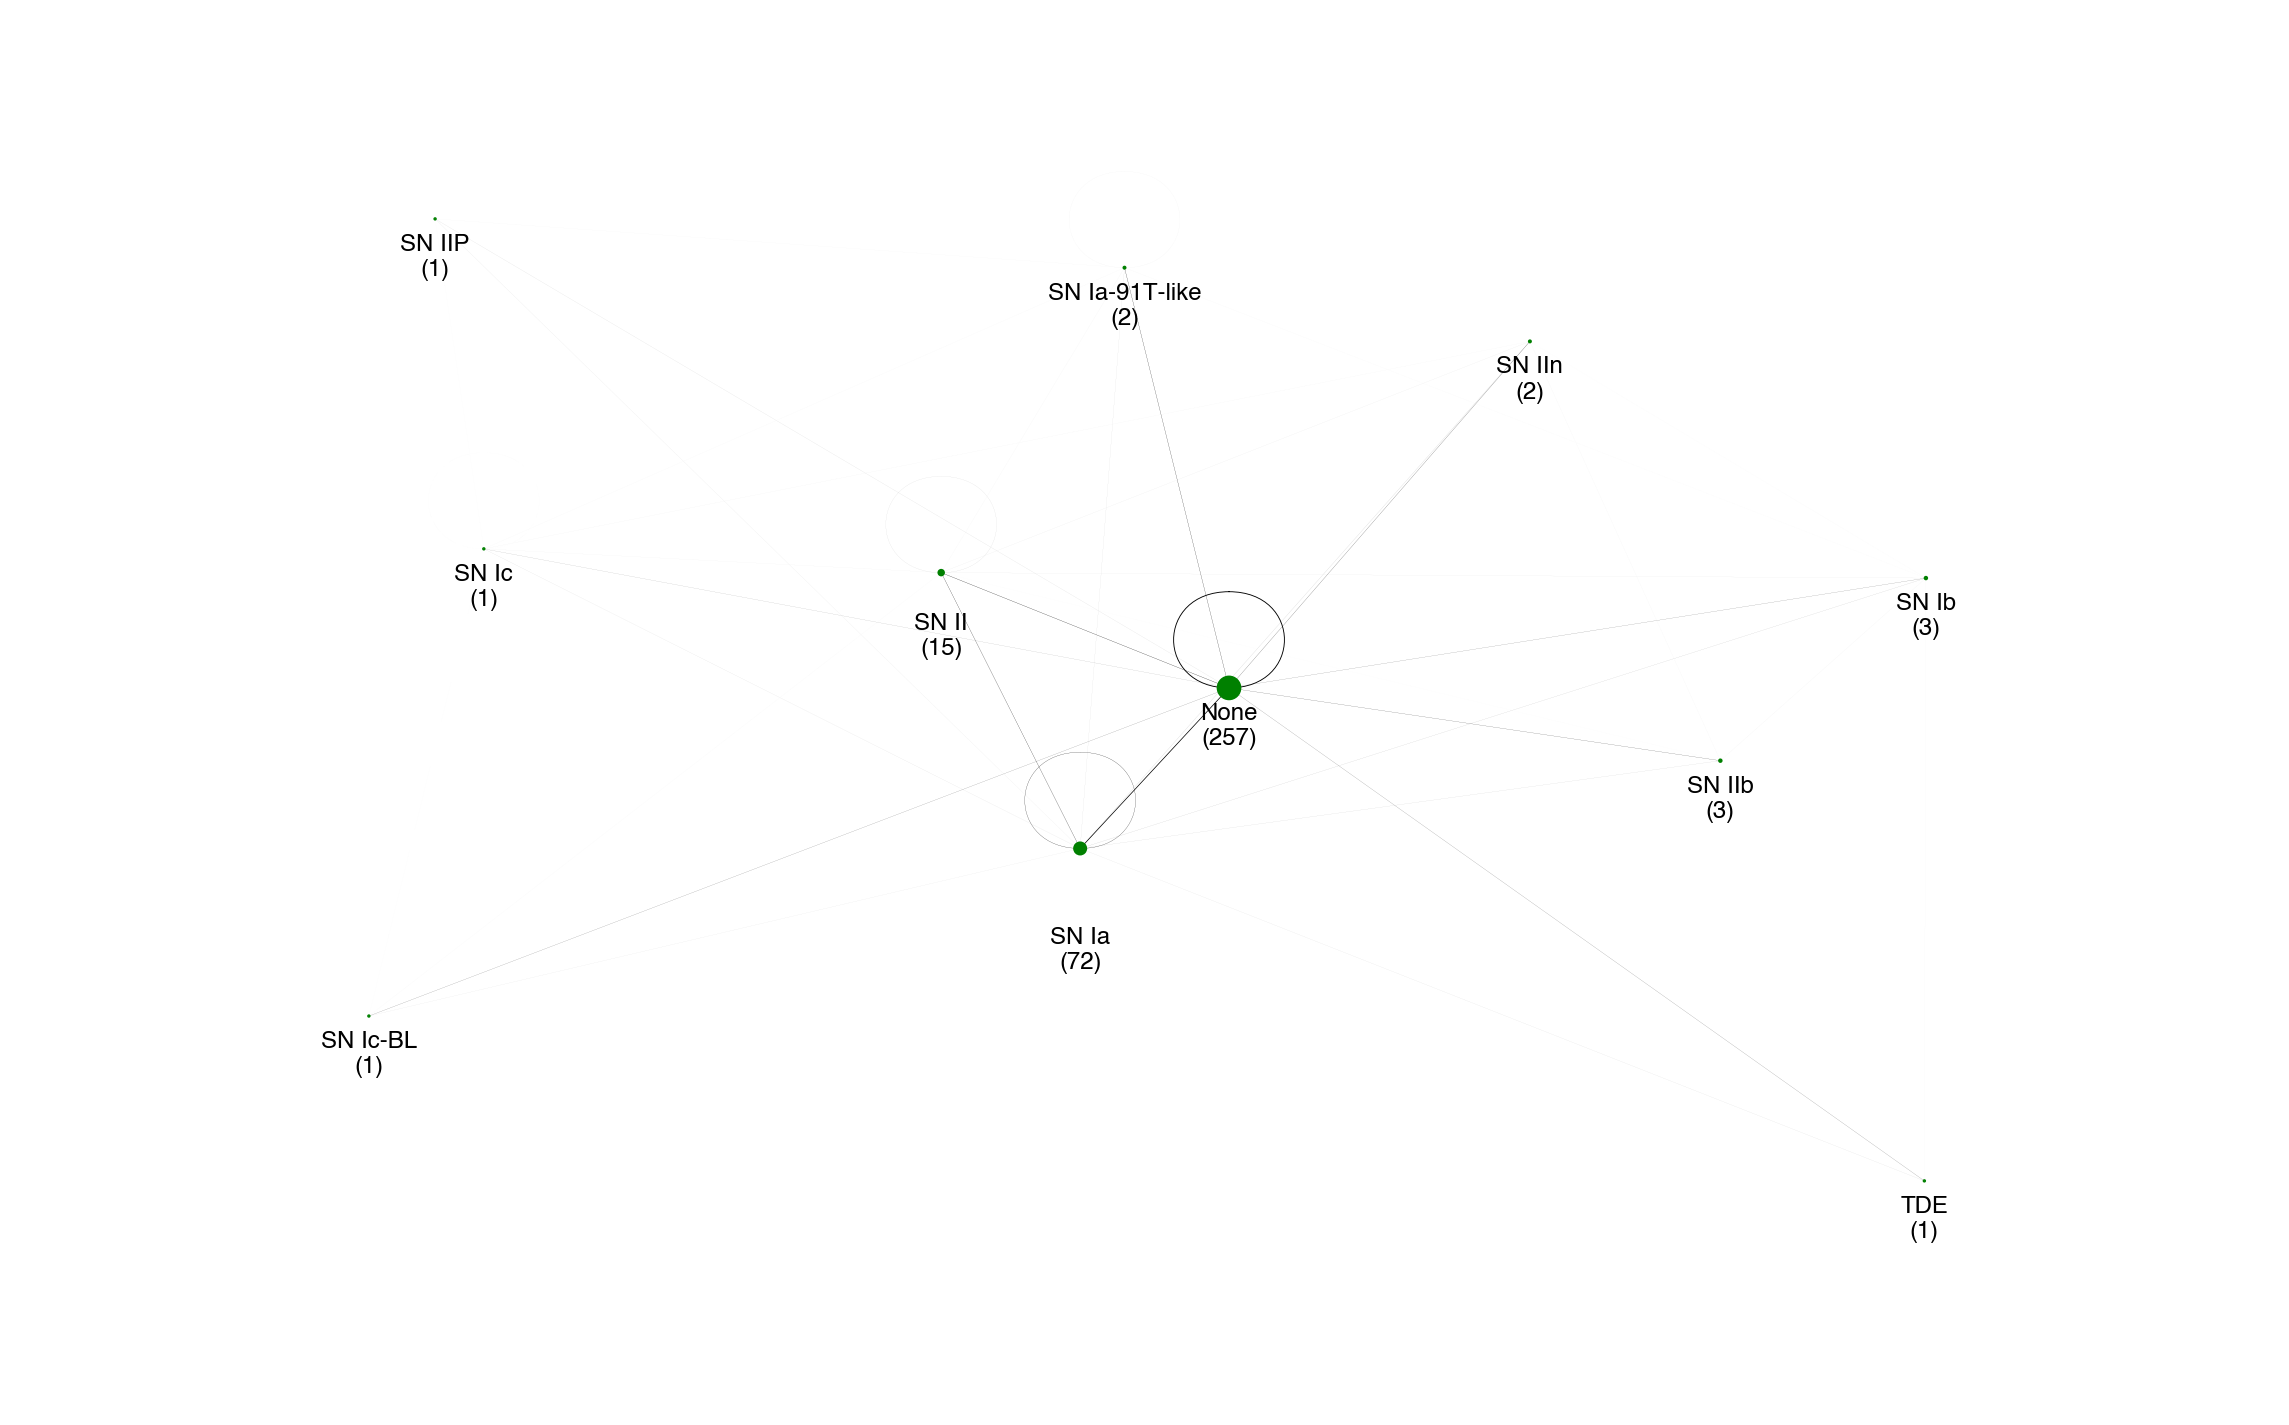

In [37]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


# Create a sample dataframe with node and edge data
df = graph_df.copy()
# Create a list of edges
edges = [(row['node'], to) for _, row in df.iterrows() for to in row['neighbors']]

# Create a network graph from the edges
G = nx.Graph()
G.add_edges_from(edges)

# Compute the frequency of each unique connection
edge_freq = {}
for u, v in edges:
    key = (min(u, v), max(u, v))
    edge_freq[key] = edge_freq.get(key, 0) + 1
    
# Add edge labels with frequency
edge_labels = {}
for u, v, d in G.edges(data=True):
    key = (min(u, v), max(u, v))
    #if edge_freq[key] >= 500:
    edge_labels[(u, v)] = str(edge_freq[key])
    
# set edge widths based on frequency
edge_widths = [int(edge_labels[edge])/2000 for edge in edge_labels]

node_count = dict(Counter(graph_df['node']))

# Scale the node sizes by the occurrences of the node
#node_sizes = [1.2 * sum(1 for x in edges if x[0] == node or x[1] == node) for node in G.nodes()]
        
node_sizes = [node_count[node] * 0.5 for node in G.nodes()]
#print(node_sizes)

# Plot the graph
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(16, 10))
nx.draw_networkx_nodes(G, pos, node_color='g', node_size=node_sizes)
nx.draw_networkx_edges(G, pos, edge_color='k', width=edge_widths)

# Move the labels of the nodes down right below the node
pos_labels = {}
for key, value in pos.items():
    pos_labels[key] = (value[0], value[1] - 0.07)
    
# count the number of times of each node 
node_count = dict(Counter(df['node']))

# scale node sizes by frequency
#node_sizes = [node_count[node] * 9 for node in G.nodes()]

# create labels with node and count information
node_labels_d1 = {node: f"{node}\n({node_count[node]})" for node in G.nodes() if node!='SN Ia' and node!='SN II'}
node_labels_d2 = {node: f"\n\n{node}\n({node_count[node]})" for node in G.nodes() if node=='SN II'}
node_labels = {node: f"\n\n\n\n\n{node}\n({node_count[node]})" for node in G.nodes() if node=='SN Ia'}

node_labels_d2.update(node_labels_d1)
node_labels.update(node_labels_d2)

nx.draw_networkx_labels(G, pos_labels, labels=node_labels, font_size=12, font_color='black')

#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12, font_color='black', font_weight='bold')

plt.axis('off')
axis = plt.gca()
axis.set_xlim([1.2*x for x in axis.get_xlim()])
axis.set_ylim([1.2*y for y in axis.get_ylim()])
plt.tight_layout()
plt.savefig(f'../figures/graphs/{suffix}_size_scaled.jpg', dpi=300)
plt.show()


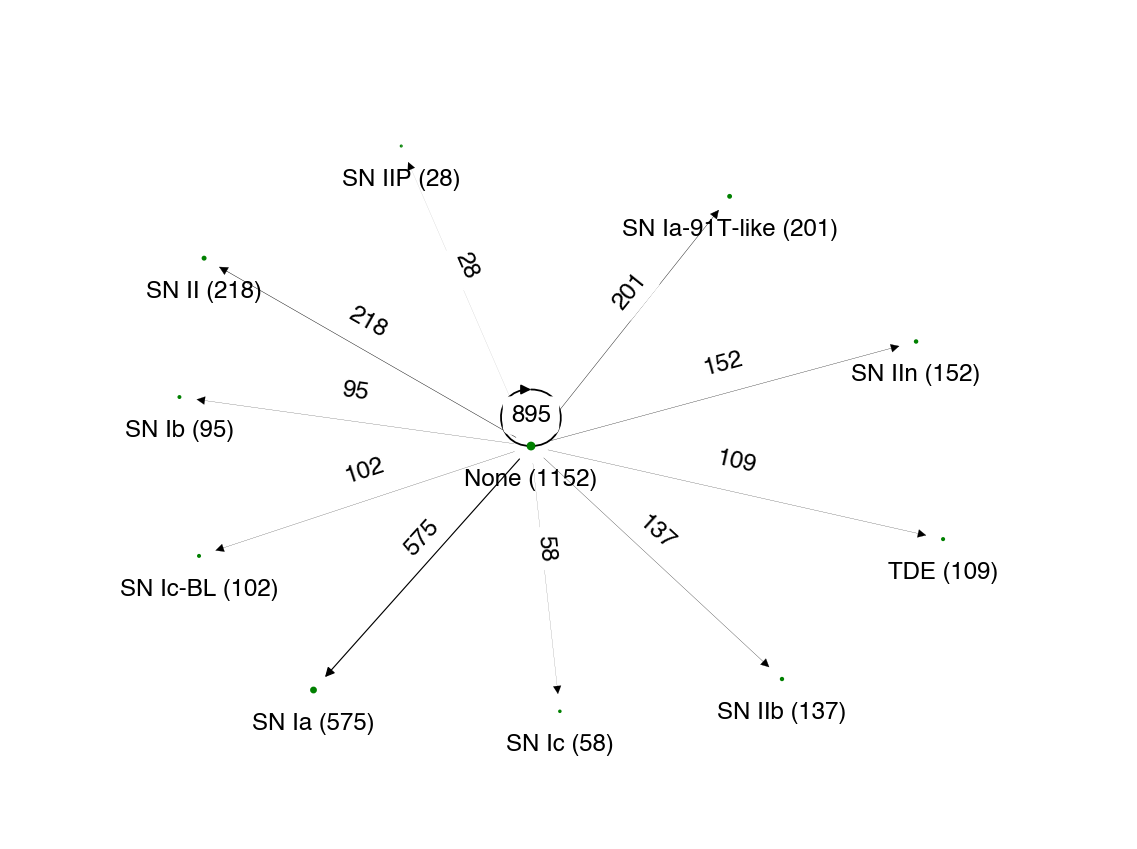

In [38]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

cls = 'None'
graph_df_cls = graph_df[graph_df.node == cls]


# Create a sample dataframe with node and edge data
df = graph_df_cls
# Create a list of edges
edges = [(row['node'], to) for _, row in df.iterrows() for to in row['neighbors']]

# Create a network graph from the edges
G = nx.DiGraph()
G.add_edges_from(edges)

# Compute the frequency of each unique connection
edge_freq = {}
for u, v in edges:
    key = (min(u, v), max(u, v))
    edge_freq[key] = edge_freq.get(key, 0) + 1
    
# Add edge labels with frequency
edge_labels = {}
for u, v, d in G.edges(data=True):
    key = (min(u, v), max(u, v))
    #if edge_freq[key] >= 500:
    edge_labels[(u, v)] = str(edge_freq[key])
    
# set edge widths based on frequency
edge_widths = [int(edge_labels[edge])/1000 for edge in edge_labels]

# Scale the node sizes by the occurrences of the node
#node_sizes = [10 * sum(1 for x in edges if x[0] == node or x[1] == node) for node in G.nodes()]
#print(node_sizes)

# explode the lists in the second column into separate rows
df = graph_df_cls
df_expl = df.explode('neighbors')

# group the data frame by the label column and count the number of unique values for each group
unique_node_d = dict(Counter(df['node']))
unique_neighbors_d = dict(Counter(df_expl['neighbors']))

for key in unique_neighbors_d:
    if key in unique_node_d:
        unique_node_d[key] += unique_neighbors_d[key]
    else:
        unique_node_d[key] = unique_neighbors_d[key]
        
node_count = unique_node_d
node_sizes = [node_count[node] * 0.01 for node in G.nodes()]
#print(node_sizes)

# Plot the graph
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_nodes(G, pos, node_color='g', node_size=node_sizes)
nx.draw_networkx_edges(G, pos, edge_color='k', width=edge_widths)

# Move the labels of the nodes down right below the node
pos_labels = {}
for key, value in pos.items():
    pos_labels[key] = (value[0], value[1] +.1)
    
    
# # count the number of times of each node 
# node_count = dict(Counter(graph_df_cv['node']))

# # scale node sizes by frequency
# node_sizes = [node_count[node] * 9 for node in G.nodes()]

# create labels with node and count information
node_labels = {node: f"\n\n\n\n\n{node} ({node_count[node]})" for node in G.nodes()}

nx.draw_networkx_labels(G, pos_labels, labels=node_labels, font_size=12, font_color='black')

nx.draw_networkx_edge_labels(G, pos_labels, edge_labels=edge_labels, font_size=12, font_color='black', font_weight='bold')


plt.axis('off')
axis = plt.gca()
axis.set_xlim([1.2*x for x in axis.get_xlim()])
axis.set_ylim([1.2*y for y in axis.get_ylim()])
plt.tight_layout()
#plt.savefig(f'../figures/graphs/{suffix}_size_scaled_None.jpg', dpi=300)
plt.show()


None


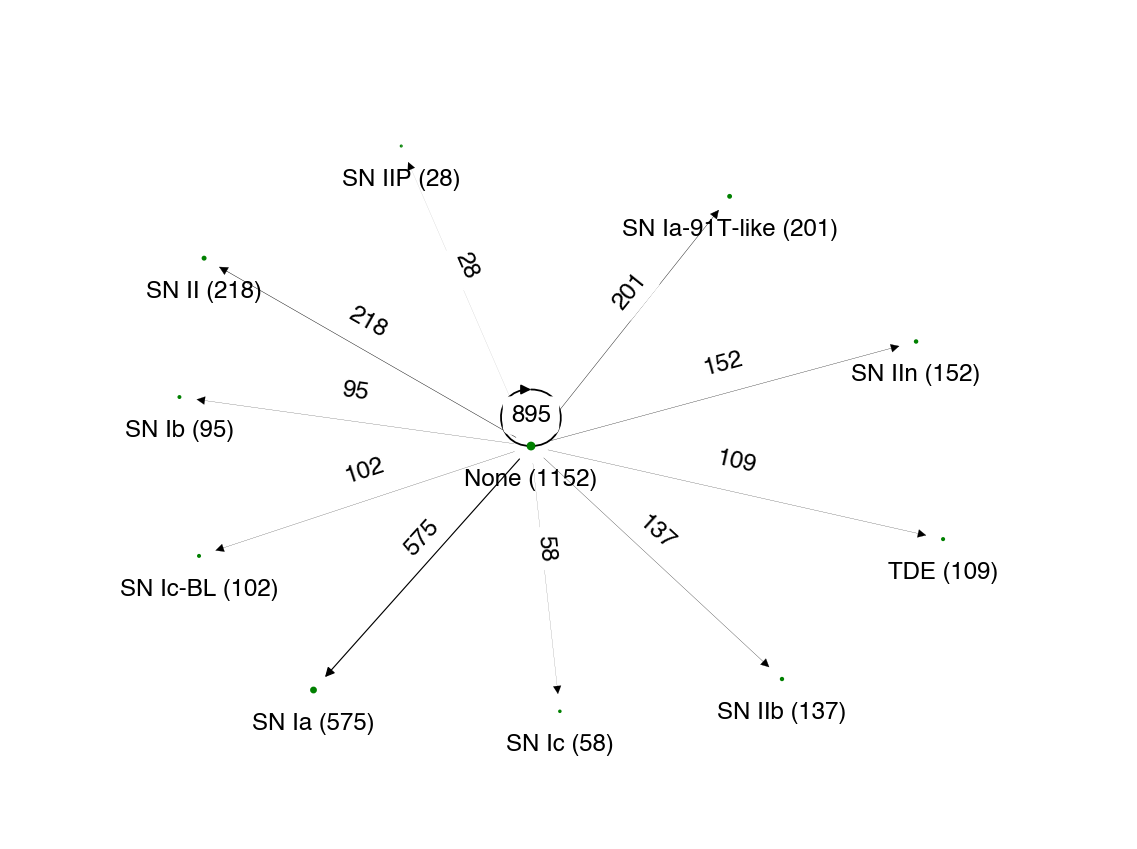

SN II


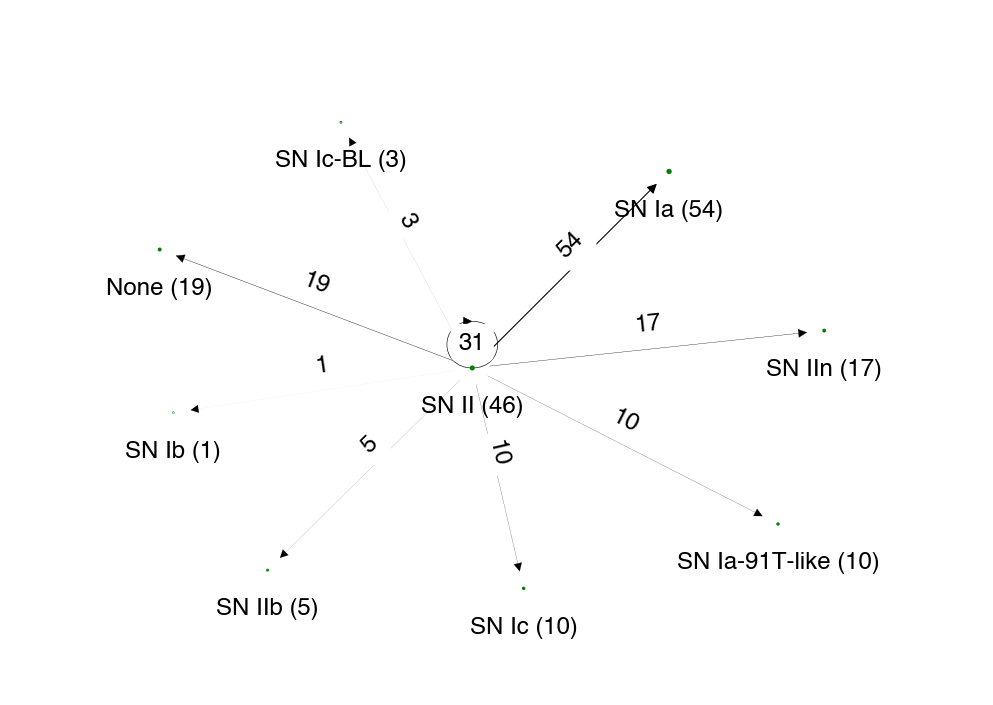

SN IIP


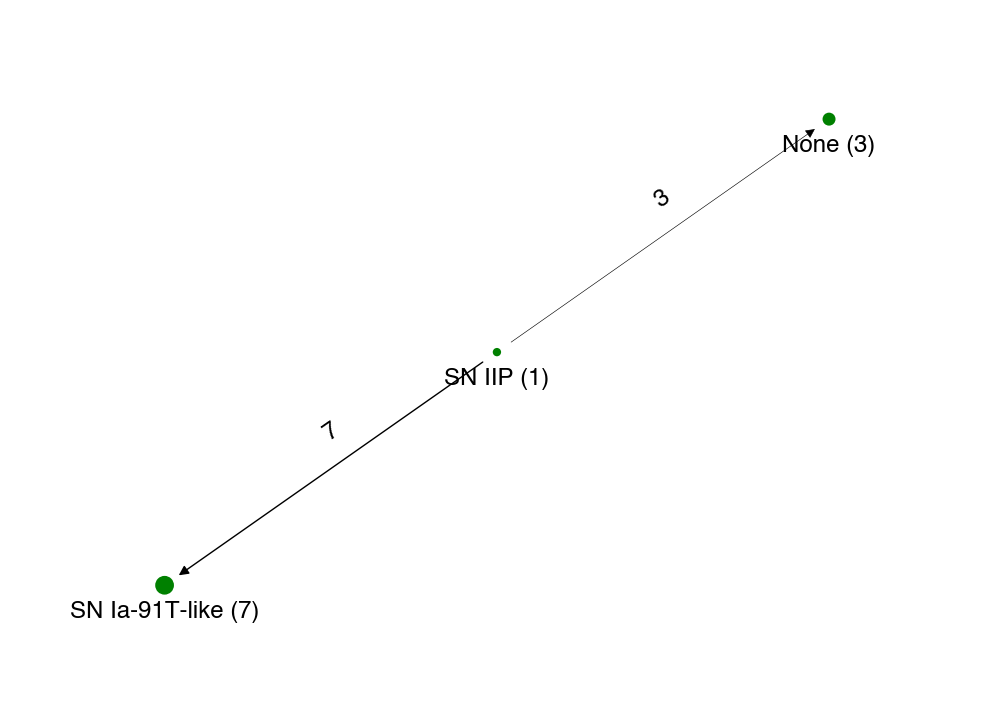

SN IIb


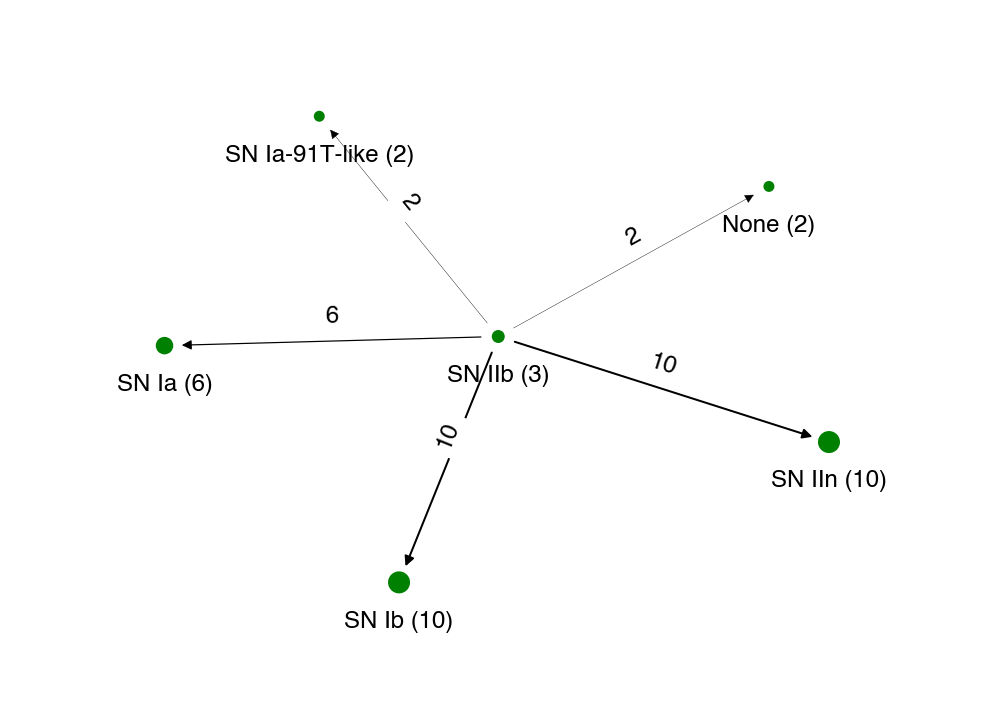

SN IIn


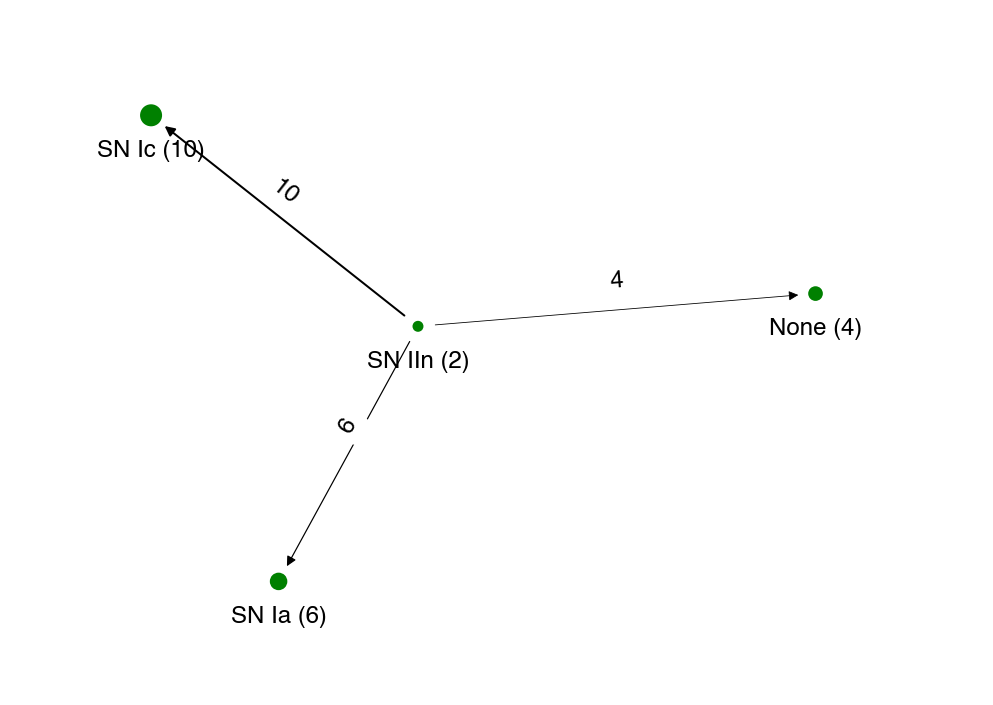

SN Ia


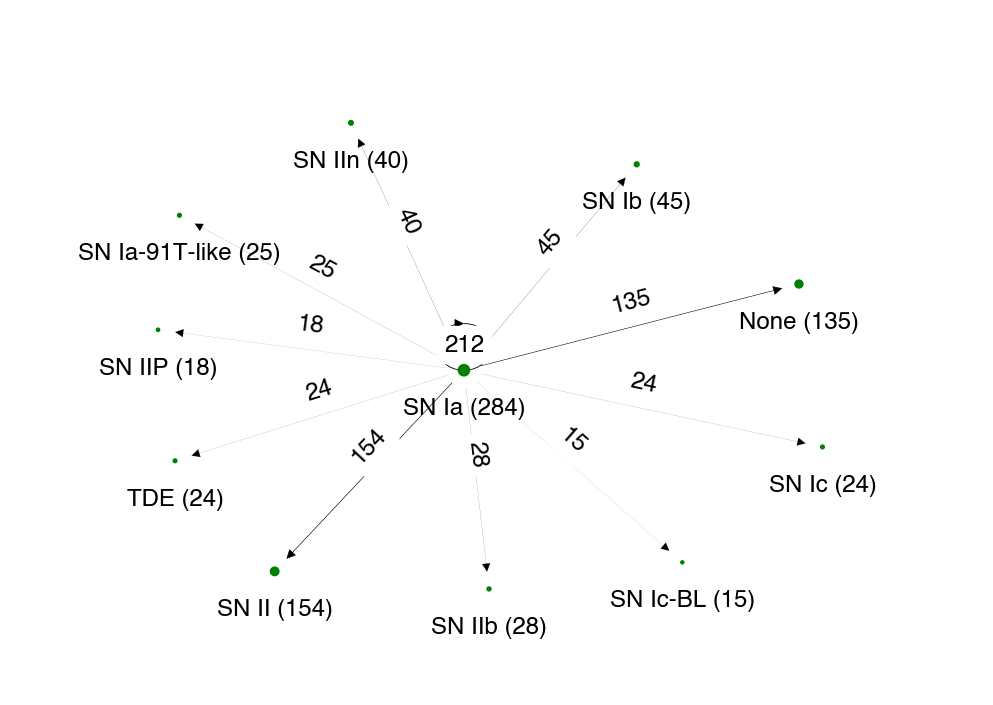

SN Ia-91T-like


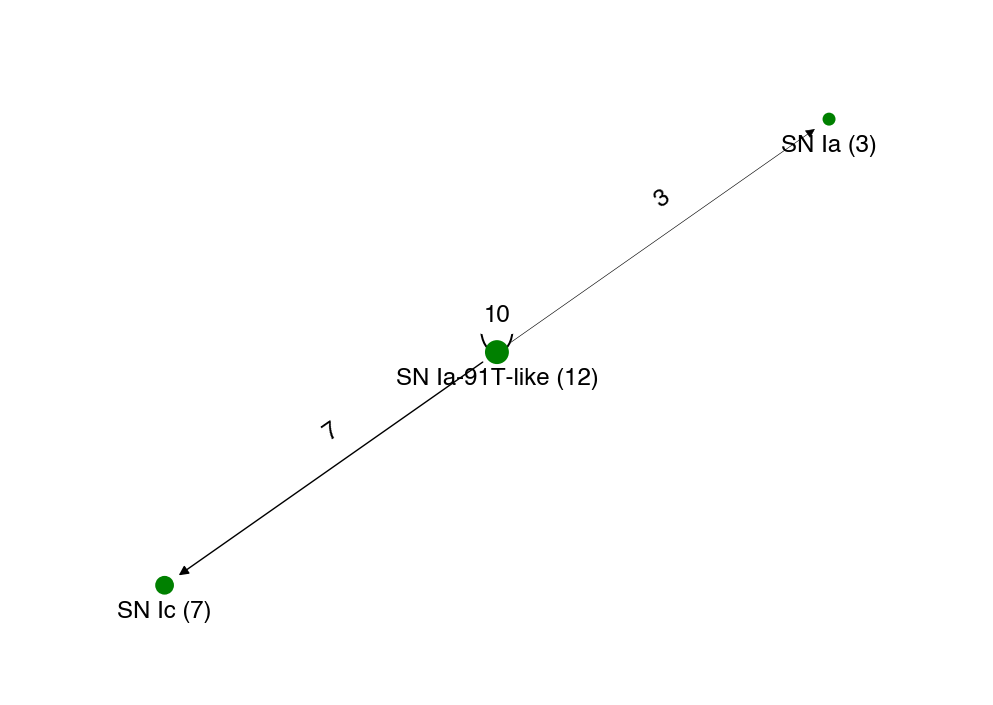

SN Ib


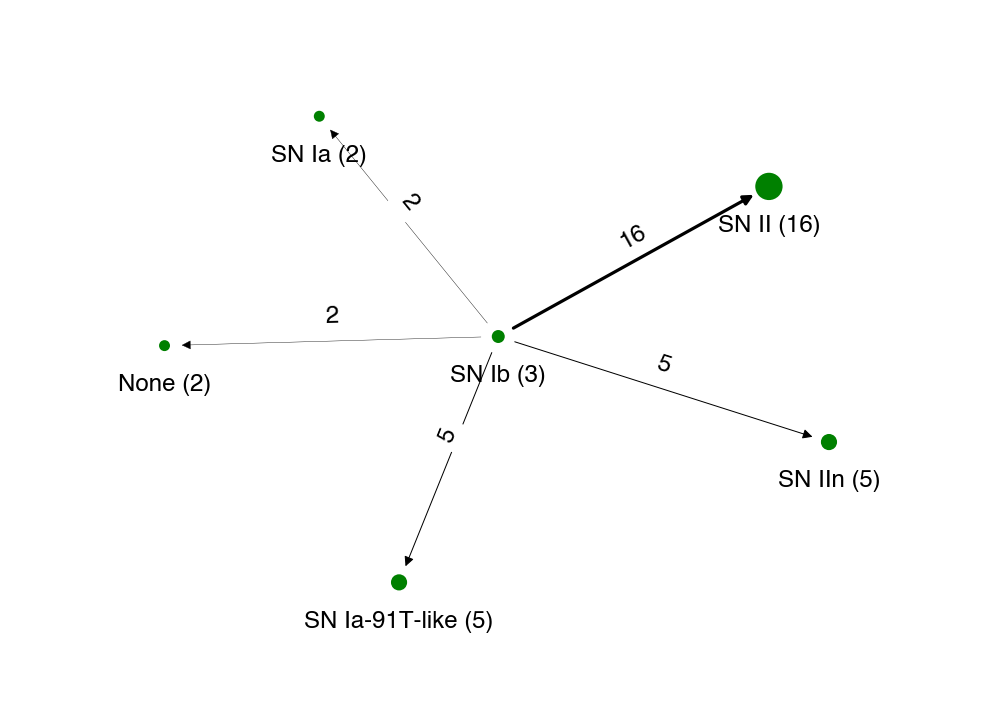

SN Ic


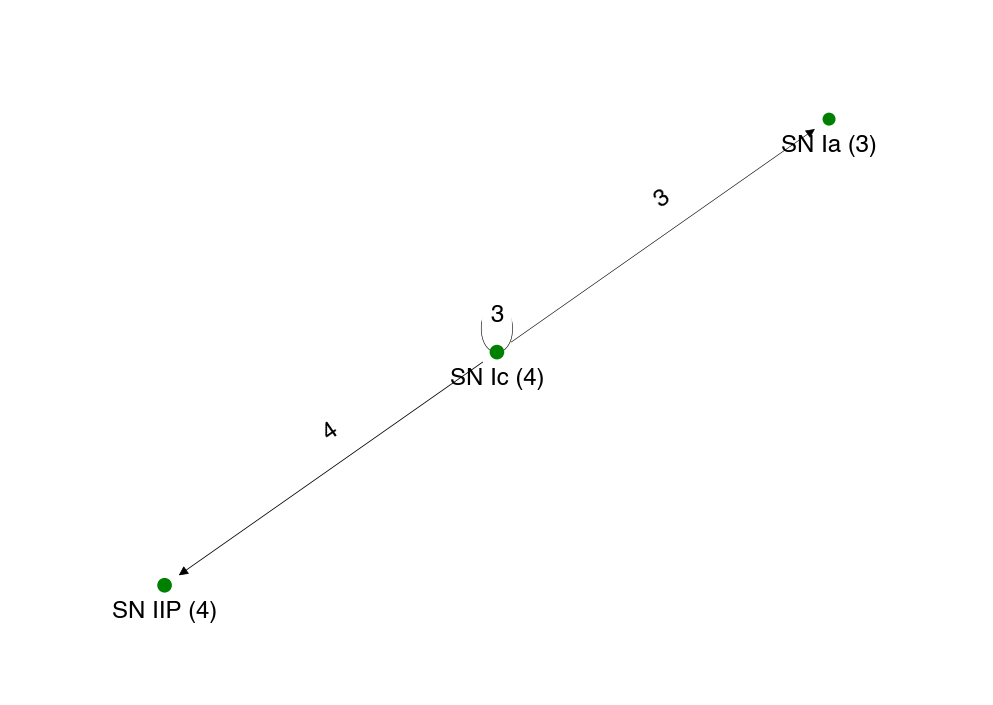

SN Ic-BL


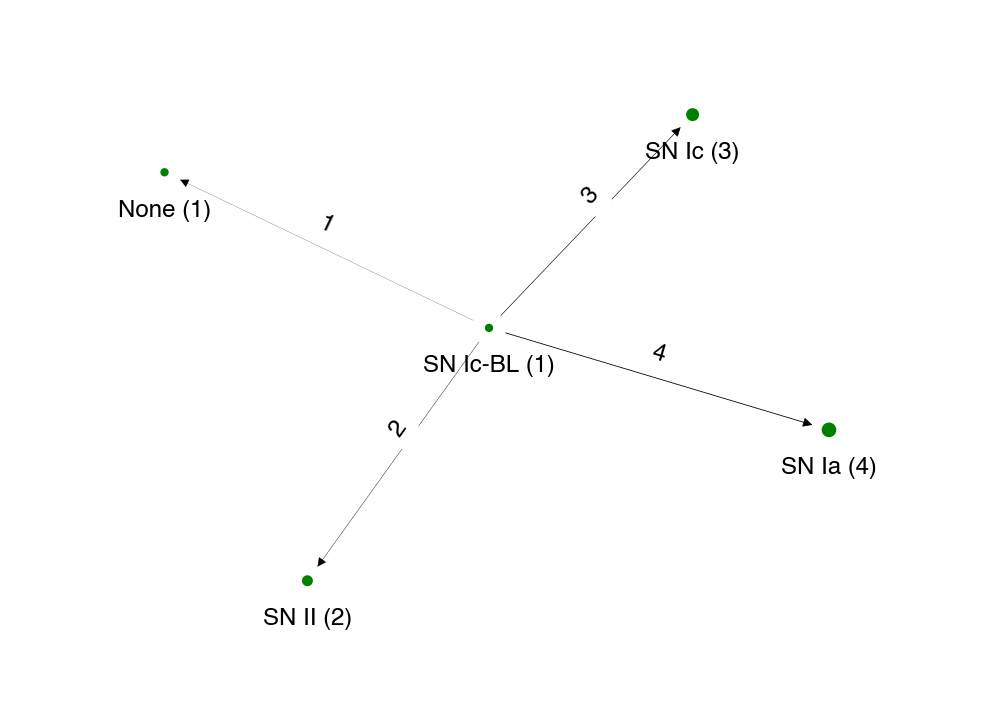

TDE


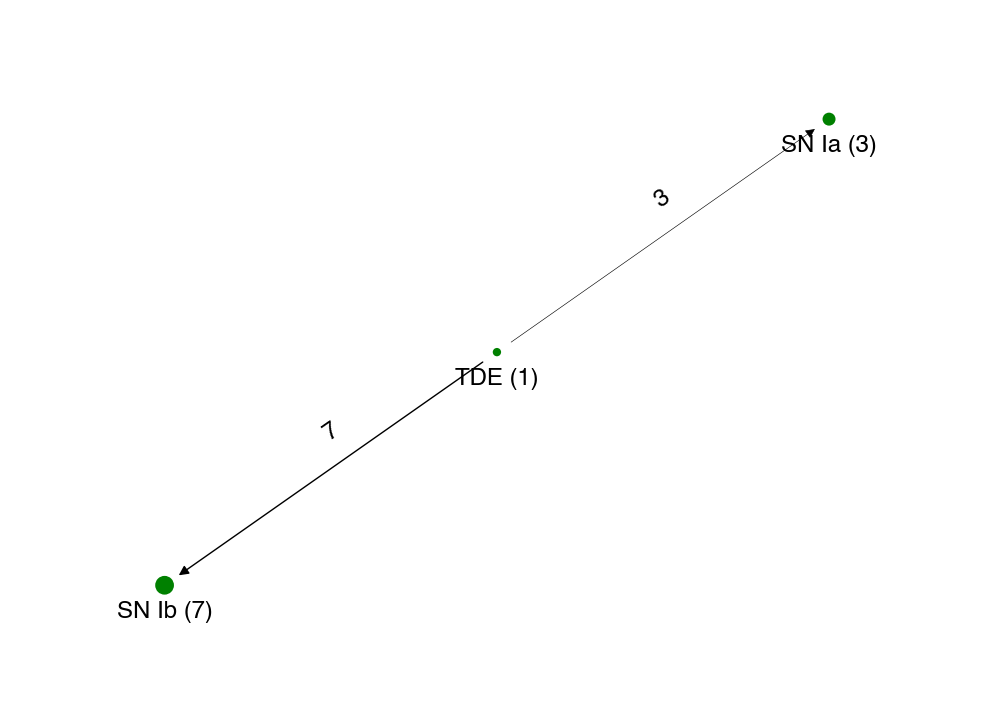

In [39]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

for cls in np.unique(graph_df['node']):
    print(cls)
    
    graph_df_cls = graph_df[graph_df.node == cls]


    # Create a sample dataframe with node and edge data
    df = graph_df_cls
    # Create a list of edges
    edges = [(row['node'], to) for _, row in df.iterrows() for to in row['neighbors']]

    # Create a network graph from the edges
    G = nx.DiGraph()
    G.add_edges_from(edges)

    # Compute the frequency of each unique connection
    edge_freq = {}
    for u, v in edges:
        key = (min(u, v), max(u, v))
        edge_freq[key] = edge_freq.get(key, 0) + 1

    # Add edge labels with frequency
    edge_labels = {}
    for u, v, d in G.edges(data=True):
        key = (min(u, v), max(u, v))
        #if edge_freq[key] >= 500:
        edge_labels[(u, v)] = str(edge_freq[key])

        # set edge widths based on frequency
        if cls == 'SN Ia': edge_widths = [int(edge_labels[edge])/500 for edge in edge_labels]
        elif cls == 'SN II': edge_widths = [int(edge_labels[edge])/100 for edge in edge_labels]
        elif cls == 'None': edge_widths = [int(edge_labels[edge])/1000 for edge in edge_labels]
        else: edge_widths = [int(edge_labels[edge])/10 for edge in edge_labels]

        # Scale the node sizes by the occurrences of the node
        #node_sizes = [10 * sum(1 for x in edges if x[0] == node or x[1] == node) for node in G.nodes()]
        #print(node_sizes)

        # explode the lists in the second column into separate rows
        df_expl = df.explode('neighbors')

        # group the data frame by the label column and count the number of unique values for each group
        unique_node_d = dict(Counter(df['node']))
        unique_neighbors_d = dict(Counter(df_expl['neighbors']))

        for key in unique_neighbors_d:
            if key in unique_node_d:
                unique_node_d[key] += unique_neighbors_d[key]
            else:
                unique_node_d[key] = unique_neighbors_d[key]

    node_count = unique_node_d
    
    if cls == 'SN Ia': node_sizes = [node_count[node] * 0.1 for node in G.nodes()]
    elif cls == 'SN II': node_sizes = [node_count[node] * 0.05 for node in G.nodes()]
    elif cls == 'None': node_sizes = [node_count[node] * 0.01 for node in G.nodes()]
    else: node_sizes = [node_count[node] * 10 for node in G.nodes()]
    #print(node_sizes)

    # Plot the graph
    pos = nx.spring_layout(G, seed=42)

    nx.draw_networkx_nodes(G, pos, node_color='g', node_size=node_sizes)
    nx.draw_networkx_edges(G, pos, edge_color='k', width=edge_widths)

    # Move the labels of the nodes down right below the node
    pos_labels = {}
    for key, value in pos.items():
        pos_labels[key] = (value[0], value[1] +.1)


    # # count the number of times of each node 
    # node_count = dict(Counter(graph_df_cv['node']))

    # # scale node sizes by frequency
    # node_sizes = [node_count[node] * 9 for node in G.nodes()]

    # create labels with node and count information
    node_labels = {node: f"\n\n\n\n\n{node} ({node_count[node]})" for node in G.nodes()}

    nx.draw_networkx_labels(G, pos_labels, labels=node_labels, font_size=12, font_color='black')

    nx.draw_networkx_edge_labels(G, pos_labels, edge_labels=edge_labels, font_size=12, font_color='black', font_weight='bold')

    cls = cls.replace(' ', '').replace('/','')
#     plt.axis('off')
#     plt.savefig(f'../figures/graphs/{suffix}_size_scaled_{cls}.jpg', dpi=300)
#     plt.show()

    plt.axis('off')
    axis = plt.gca()
    axis.set_xlim([1.2*x for x in axis.get_xlim()])
    axis.set_ylim([1.2*y for y in axis.get_ylim()])
    plt.tight_layout()
    plt.savefig(f'../figures/graphs/{suffix}_size_scaled_{cls}.jpg', dpi=300)
    plt.show()


In [45]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN Ia-91T-like']

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,ann=10_tns_cls
ZTF20achuvhd,SN Ia-91T-like,SN Ia,SN Ia,SN Ia,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic
ZTF21aagnvvk,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like


In [47]:
full_ann_properties_df.loc['ZTF20achuvhd']

ann=0_ztfid         ZTF20achuvhd
ann=1_ztfid          ZTFabc30171
ann=2_ztfid          ZTFabc27032
ann=3_ztfid          ZTFabc60925
ann=4_ztfid          ZTFabc06789
ann=5_ztfid          ZTFabc68350
ann=6_ztfid          ZTFabc49155
ann=7_ztfid          ZTFabc44529
ann=8_ztfid          ZTFabc94641
ann=9_ztfid          ZTFabc39676
ann=10_ztfid         ZTFabc63609
ann=0_d                        0
ann=1_d                 168.6631
ann=2_d                 174.1784
ann=3_d                 187.8327
ann=4_d                 190.5221
ann=5_d                 190.8228
ann=6_d                 190.8398
ann=7_d                 190.9843
ann=8_d                 191.0267
ann=9_d                 192.8075
ann=10_d                193.6084
ann=0_has_tns            Yes_TNS
ann=1_has_tns               Fake
ann=2_has_tns               Fake
ann=3_has_tns               Fake
ann=4_has_tns               Fake
ann=5_has_tns               Fake
ann=6_has_tns               Fake
ann=7_has_tns               Fake
ann=8_has_

In [46]:
full_ann_properties_df.loc['ZTF21aagnvvk']

ann=0_ztfid         ZTF21aagnvvk
ann=1_ztfid          ZTFabc81115
ann=2_ztfid          ZTFabc16416
ann=3_ztfid          ZTFabc21708
ann=4_ztfid         ZTF21aaahliy
ann=5_ztfid          ZTFabc09781
ann=6_ztfid          ZTFabc07055
ann=7_ztfid          ZTFabc34779
ann=8_ztfid          ZTFabc45189
ann=9_ztfid          ZTFabc24528
ann=10_ztfid         ZTFabc08243
ann=0_d                        0
ann=1_d                 212.9454
ann=2_d                 220.2745
ann=3_d                 225.7784
ann=4_d                 226.0076
ann=5_d                 226.2967
ann=6_d                 226.4621
ann=7_d                 227.8499
ann=8_d                 228.9717
ann=9_d                 229.3471
ann=10_d                230.7903
ann=0_has_tns            Yes_TNS
ann=1_has_tns               Fake
ann=2_has_tns               Fake
ann=3_has_tns               Fake
ann=4_has_tns            Yes_TNS
ann=5_has_tns               Fake
ann=6_has_tns               Fake
ann=7_has_tns               Fake
ann=8_has_